# 1. Set-up
- Import libraries
- Define directories
- Split arrays into single, binary and weird

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as f
from os import listdir

In [8]:
#path to data
path = '/home/puck/Documents/BRP/data'

In [9]:
#list of star names
all_stars = np.array(sorted(listdir(path)))

weird_stars = np.array(['2MASSJ11320835-5803199', '2MASSJ12041439-6418516', '2MASSJ12123577-5520273', 
                        '2MASSJ12192161-6454101', '2MASSJ12205449-6457242', '2MASSJ12472196-6808397',
                        '2MASSJ12582559-7028490', '2MASSJ13032904-4723160'])

binary_stars_og = np.array(['2MASSJ11555771-5254008', '2MASSJ12560830-6926539', '2MASSJ13015435-4249422',
                            '2MASSJ13130714-4537438', 'CD-43_3604', 'CVSO_751', 'Gaia_EDR3_3008386787098934144',
                            'HD_283629', 'HD_284266', 'HD_286179', 'UCAC4_454-011718', 'UCAC4_475-014428', 
                            'UCAC4_495-030196','UCAC4_501-011878'])

binary_stars_close = np.array(['2MASSJ10065573-6352086','2MASSJ11272881-3952572','2MASSJ11445217-6438548',
                               '2MASSJ11452016-5749094','2MASSJ12163007-6711477','2MASSJ12185802-5737191',
                               '2MASSJ12210808-5212226','2MASSJ12234012-5616325','2MASSJ13055087-5304181',
                               '2MASSJ13103245-4817036','2MASSJ13174687-4456534','2MASSJ13335481-6536414',
                               'CoRoT_102718810','Gaia_EDR3_3014970387847972096','IRAS_08131-4432',
                               'RX_J2302.6+0034','UCAC4_127-038351','UCAC4_134-015937','UCAC4_406-011818',
                               'UCAC4_461-018326','UCAC4_482-118442','UCAC4_496-013657','UCAC4_519-042115',
                               'V1319_TAU'])

binary_stars = np.append(binary_stars_og,binary_stars_close)

In [10]:
def mask_arr_stars(arr, star_names):
    mask = np.ones_like(star_names, dtype = bool)
    for i in arr:
        idx = np.where(star_names == i)
        mask[idx] = False
    return mask

In [12]:
single_stars = all_stars[(mask_arr_stars(binary_stars, all_stars)*mask_arr_stars(weird_stars, all_stars))]

In [143]:
print('Single stars:',len(single_stars),'\nBinary stars:',len(binary_stars),'\nWeird stars:',len(weird_stars) )

Single stars: 64 
Binary stars: 38 
Weird stars: 8


In [144]:
#Show which stars have more than 1 file aka for which star we have more than 1 observation
mask_dates = np.array([len(listdir(f'{path}/{all_stars[i]}'))!= 1 for i in range(len(all_stars))])
more_dates = all_stars[mask_dates]
#print(more_dates)

# 2. Retrieve the data 
- Write a function which retrieves the name of the star and the date of observation
- Write a function to retrieve the data of one star
- Write a function which combines all this data into one array

In [145]:
def star_info(idx, star_names):
    ''' Returns the name of the star and the date of the observation at index idx as a tuple. '''
    return star_names[idx], listdir(f'{path}/{star_names[idx]}')[0]

In [146]:
def star_data(idx, star_names):
    ''' Returns the flux data of the star at the corresponding data at index idx as a 2d numpy array. '''
    name, date = star_info(idx, star_names)
    with f.open(f'{path}/{name}/{date}/B_H/calibration/flux/{name}_{date}_cube_flux_processed_right.fits') as hdul:
        data = hdul[0].data
    return data[0]

In [147]:
def star_data_arr(star_names):
    ''' Returns an array containing all the data if all stars in star_names. '''
    arr = np.array([star_data(0, star_names)])
    for i in range(1, len(star_names)):
        arr = np.append(arr, np.array([star_data(i, single_stars)]), axis = 0) 
    return arr

# 3. Cutting out central pixels
- Circle of radius 100 pixels around center
- 200 x 200 pixelsaround center

In [77]:
def mask_but_center(arr, r):
    ''' Masks everything but the area with radius r in a circle around the center. '''
    x = y = np.linspace(-(len(arr))/2, (len(arr))/2, len(arr))
    x_grid, y_grid = np.meshgrid(x, y)
    r_grid = np.sqrt(x_grid**2 + y_grid**2)
    arr[r_grid > r] = None 
    return arr

def normalize(arr):
    ''' Normalizes the array '''
    arr = np.array(arr,dtype=np.float64)
    return arr/np.nanmax(arr)

def calibration(arr, r):
    ''' Masks and then normalizes the array. '''
    mask_arr = mask_but_center(arr, r)
    norm_arr = normalize(mask_arr)
    return norm_arr

In [78]:
def print_stars(idx, star_names):
    ''' Print the masked and normalised flux image of the star at index idx. '''
    name, date = star_info(idx, star_names)
    star = calibration(star_data(idx, star_names), 100)
    
    plt.subplot(1, 2, 1)
    plt.imshow(star)
    plt.gca().invert_yaxis()
    plt.xlim(400, 624)
    plt.ylim(400, 624)

    plt.subplot(1, 2, 2)
    plt.imshow(star)
    plt.gca().invert_yaxis()
    plt.xlim(500, 524)
    plt.ylim(500, 524)

    plt.suptitle(f'{name}, {date}', y = 0.8)
    plt.show()

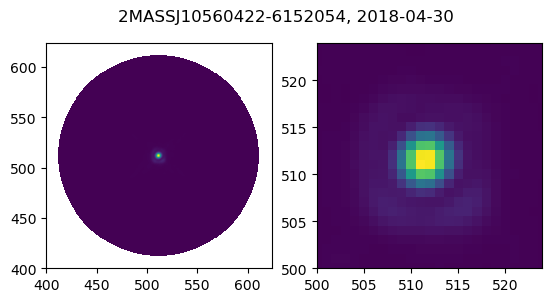

In [180]:
print_stars(0, single_stars)

In [79]:
#for i in range(len(single_stars)):
#        print_stars(i, single_stars)

In [80]:
#for i in range(len(binary_stars)):
#    print_stars(i, binary_stars)

# 3. Finding the perfect median star
- Cut out a little square far away from the star
- Calculate the RMS of each little square to determine the noise
- Combine all these RMS in an array and sort them from best to worst
- Write a function that calculates the median of an array of stars
- Write a function 

In [222]:
#x, y, dx, dy choosen in a way that we can use the same pixels when calculating the rms of the median
def rms_patch(star):
    ''' Calculates the rms of a patch of the sky. The patch is 550 till 570 in x and 450 till 470 in y. '''
    return np.std(star[550:570, 450:470])

def rms_sort_arr(star_names):
    ''' Adds all rms to an array and sorts them. '''
    arr = np.empty_like(star_names, dtype = float)
    for i in range(len(star_names)):
        arr[i] = rms_patch((star_data(i, star_names)))
    return arr[np.argsort(arr)], np.argsort(arr)

In [210]:
def median_star_arr(star_names):
    ''' Calculates the median of an array of normalised star images. '''
    arr = np.array([calibration(star_data(0, star_names), 100)])
    for i in range(1, len(star_names)):
        arr = np.append(arr, np.array([calibration(star_data(i, star_names), 100)]), axis = 0) 
    return np.median(arr, axis = 0)

In [211]:
median_star = median_star_arr(single_stars)

In [216]:
rms_med_arr = rms_patch(median_star) #rms of a normalised array

Now we want to do this but remove the worst image every time 

In [231]:
rms_s_s, rms_s_idx = rms_sort_arr(single_stars) #rms of the single stars, len is 64 [0, ...., 63]

N_keep = np.arange(0, len(rms_s_s))
print(rms_s_s, rms_s_idx[0:65], len(rms_s_s))

[2.22580194 2.40713453 2.45047736 2.58368635 2.66348124 2.68512321
 2.78970289 2.79988217 2.81539297 2.82754898 2.85672665 2.88589001
 2.91457057 2.97158074 3.0327878  3.10128355 3.12844229 3.14051557
 3.14473009 3.1476965  3.16751885 3.17028713 3.17139125 3.21297503
 3.21496868 3.2250216  3.25665927 3.2567246  3.27763462 3.35954905
 3.36446047 3.40761518 3.42687082 3.4280448  3.44081831 3.45320249
 3.46625566 3.46967816 3.49557257 3.50859928 3.524014   3.53825927
 3.57603431 3.57838392 3.57872391 3.60310245 3.62361956 3.68409991
 3.75814247 3.7994144  3.82951093 4.05192995 4.05422306 4.17567825
 4.23358488 4.26339102 4.27247715 4.4225688  4.59605598 4.64277124
 4.71187878 4.77033472 4.81322718 4.97526503] [53 62 56 54 59 45 55 15 60 61 63 57 16 58 11 51 25 17 44 49 22  9 29 20
 26 47 46  1  3  7 18 21 12  5 32 14  2 30 48 10 33 50 52  8 28 24 19 37
 43 31 13 27 38  0 41 42 34  4 40 36 35 39  6 23] 64


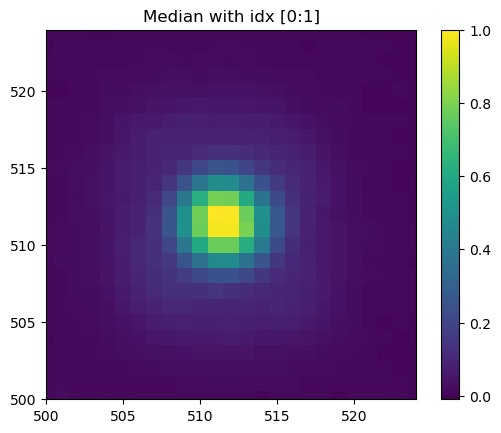

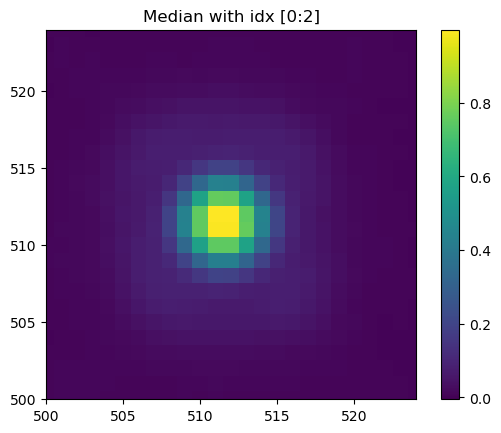

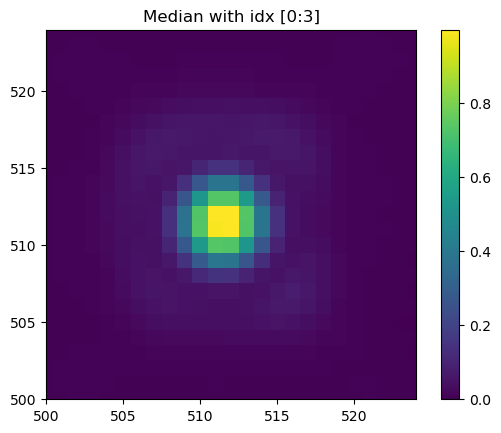

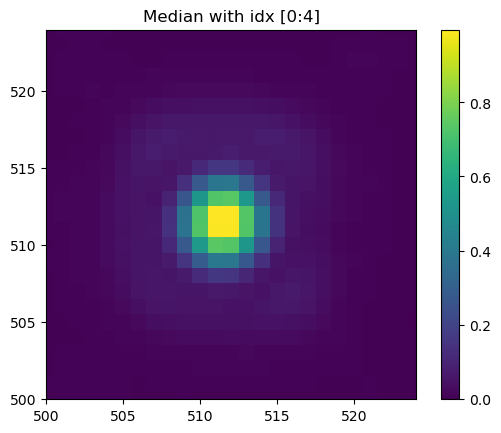

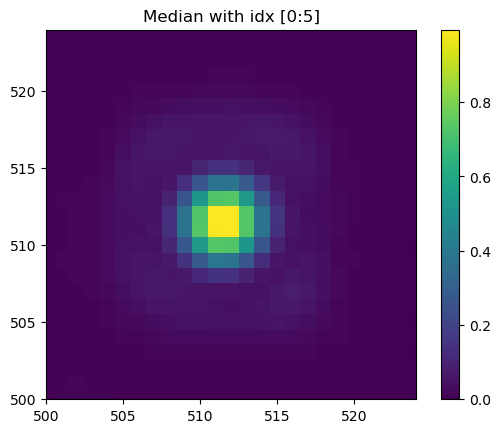

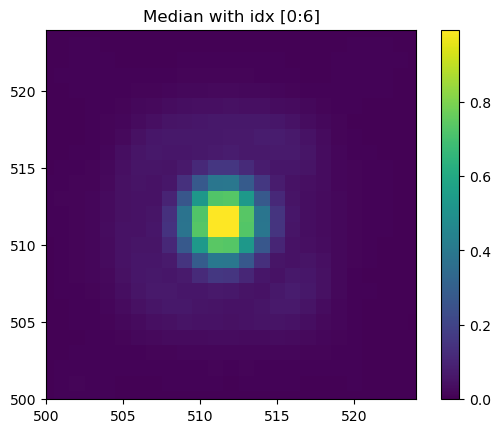

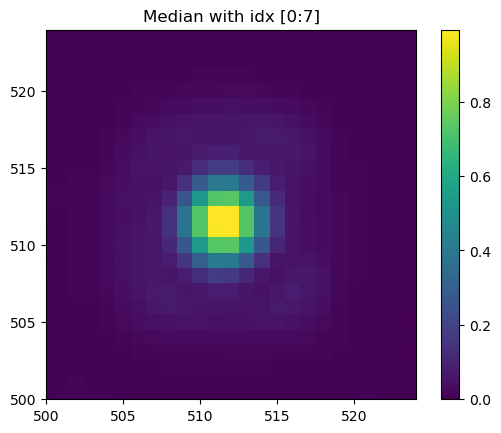

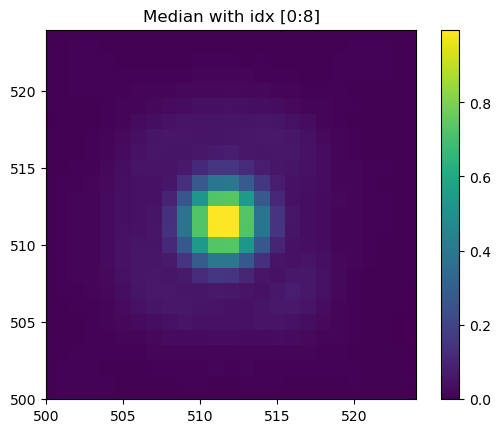

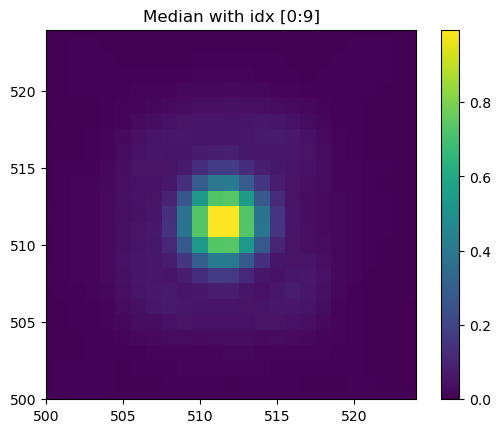

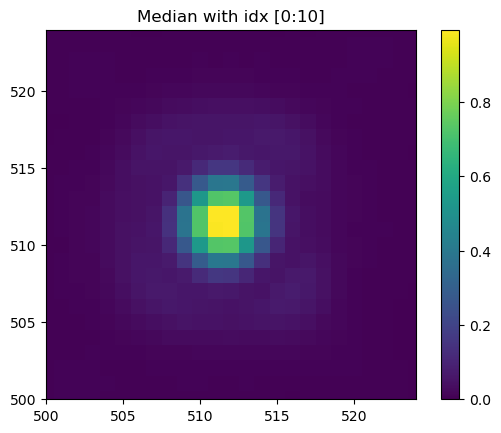

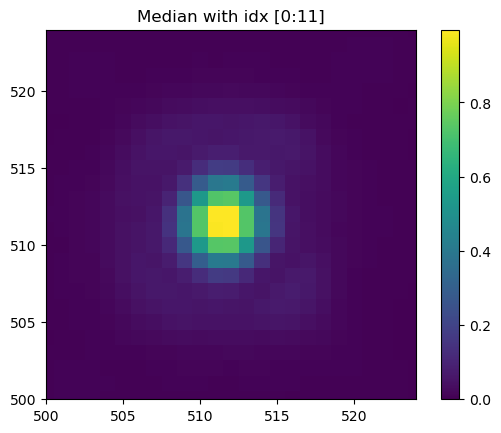

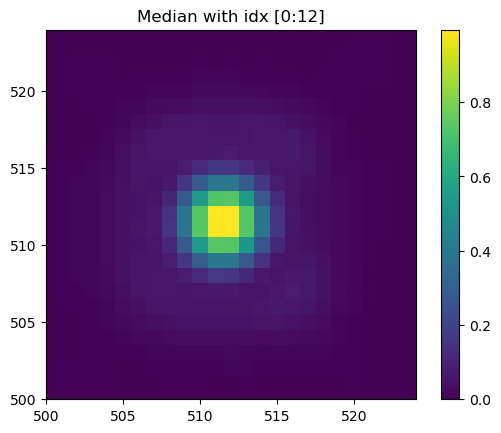

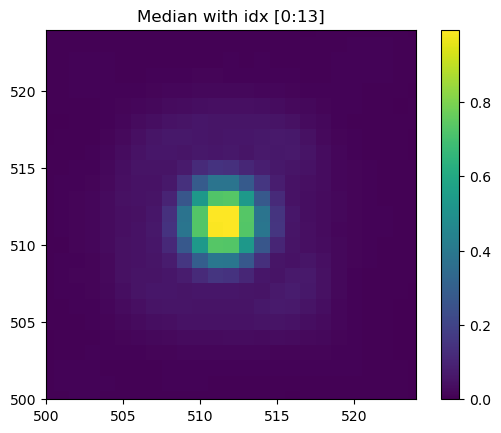

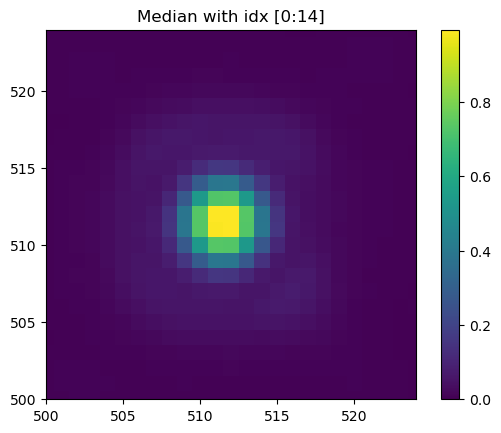

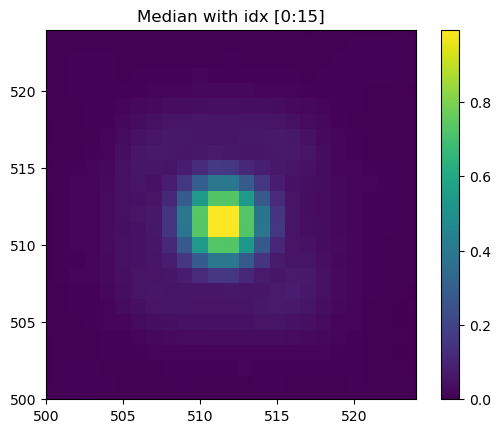

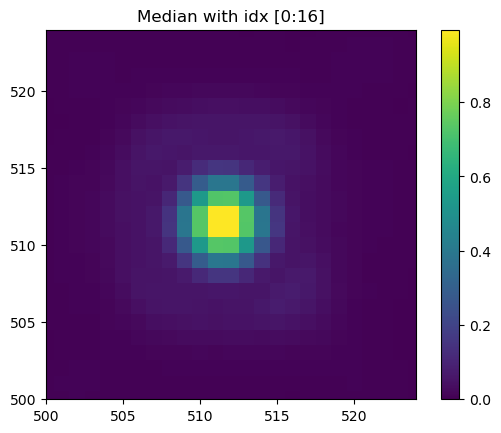

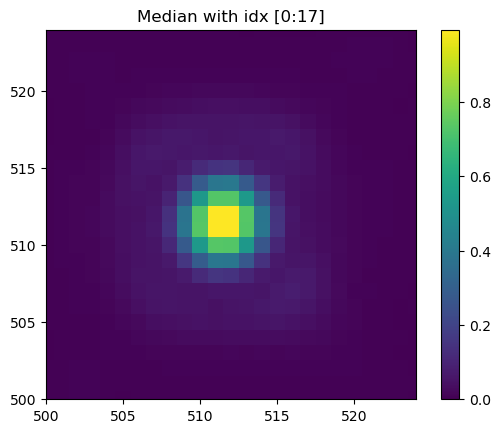

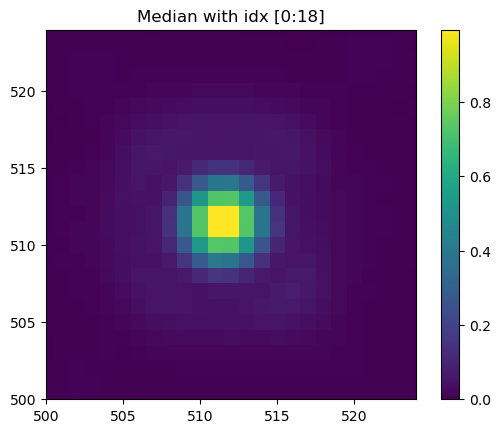

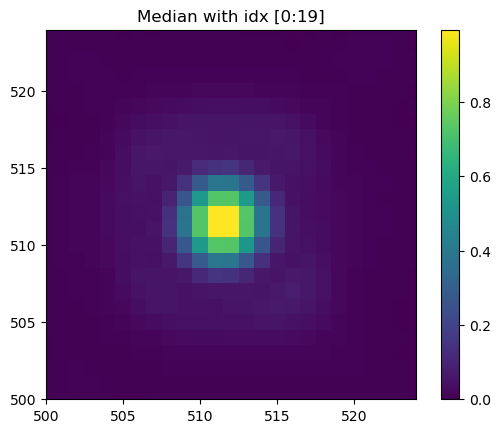

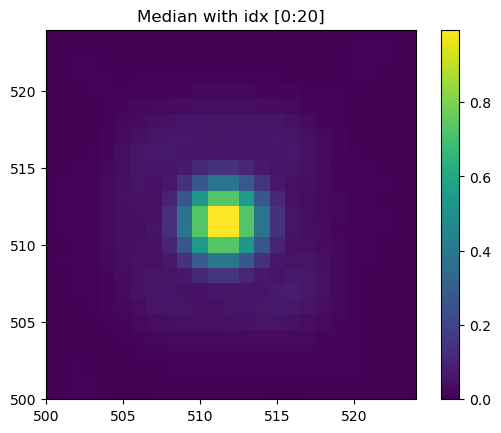

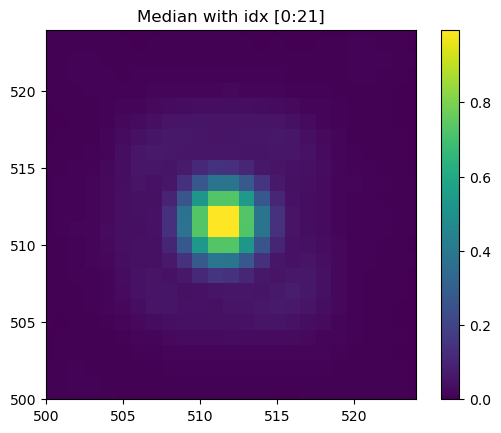

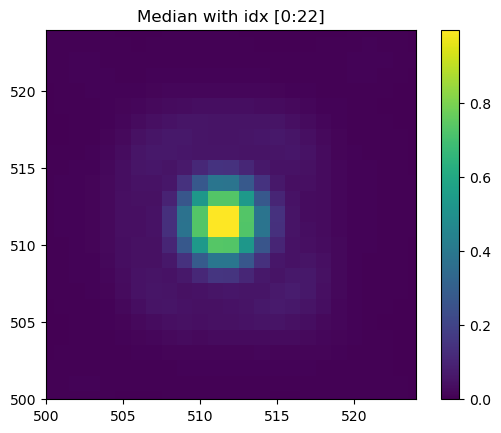

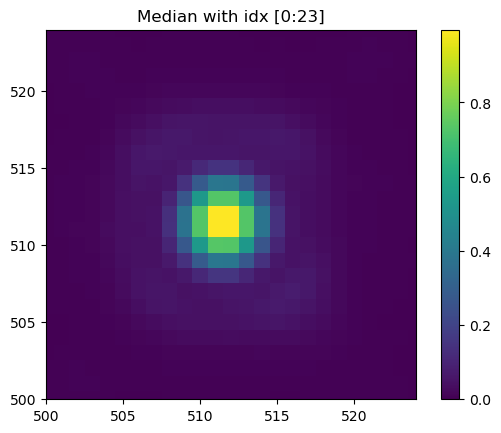

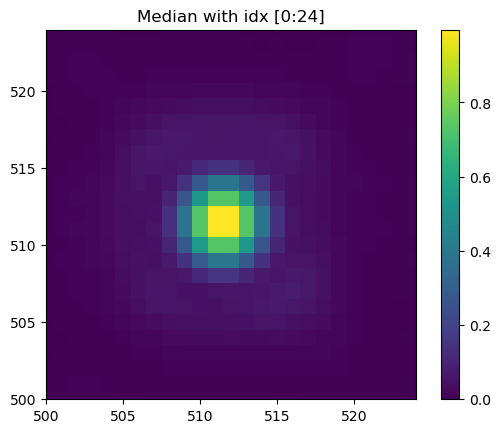

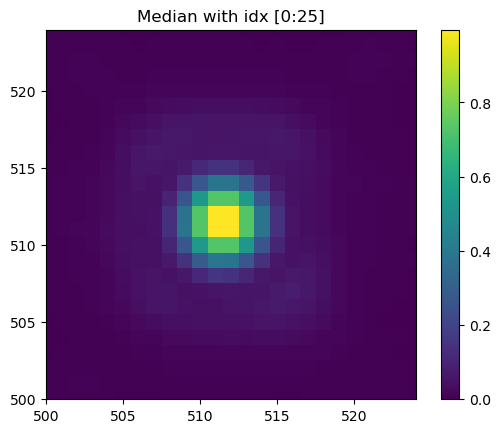

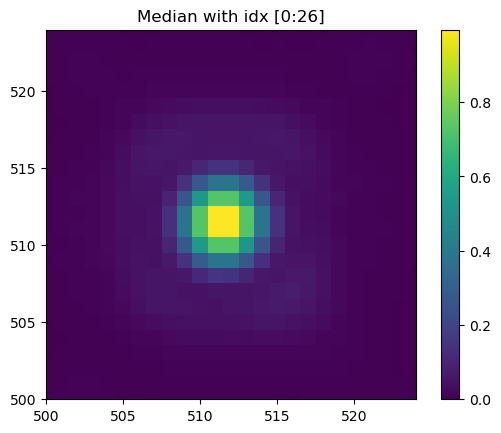

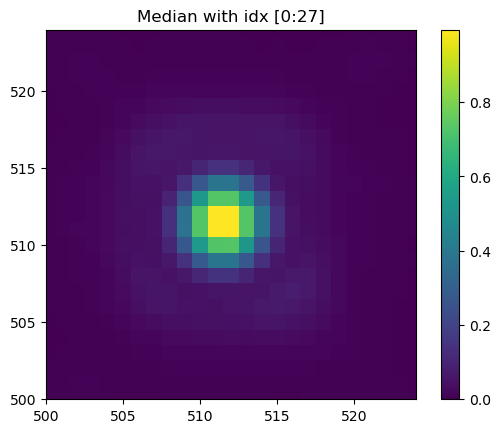

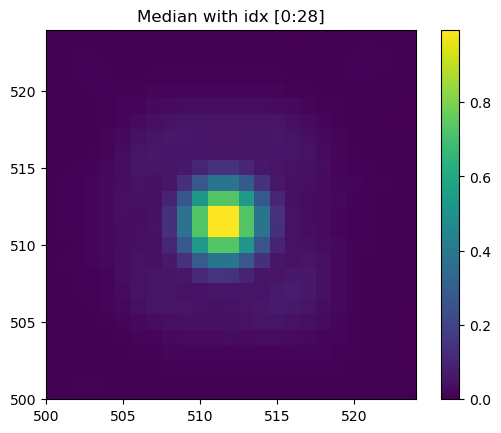

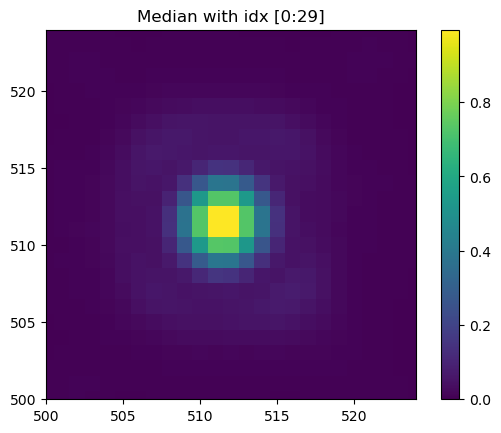

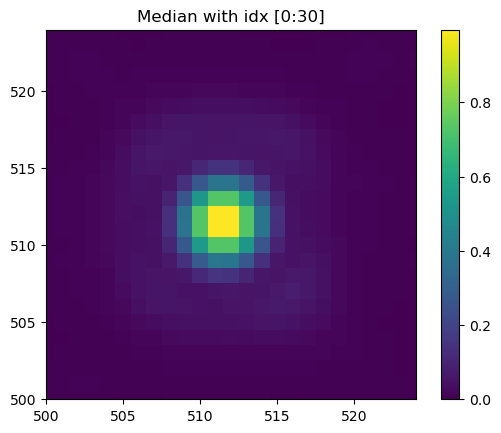

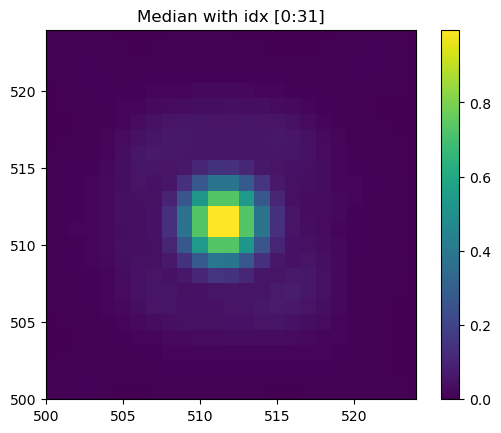

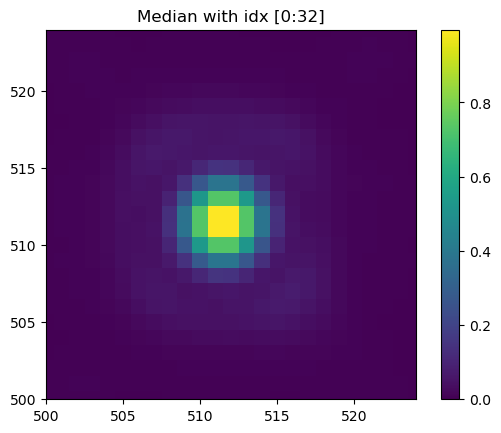

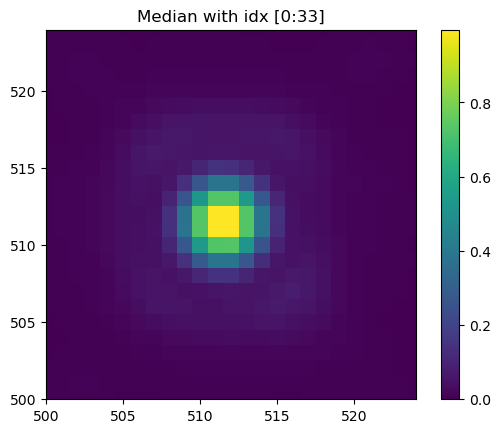

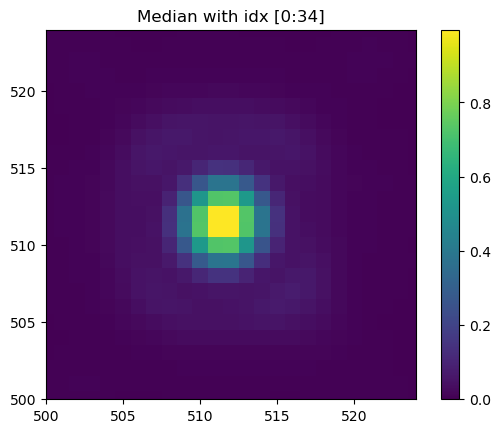

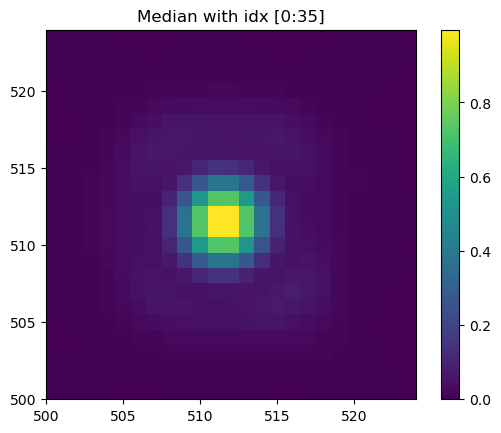

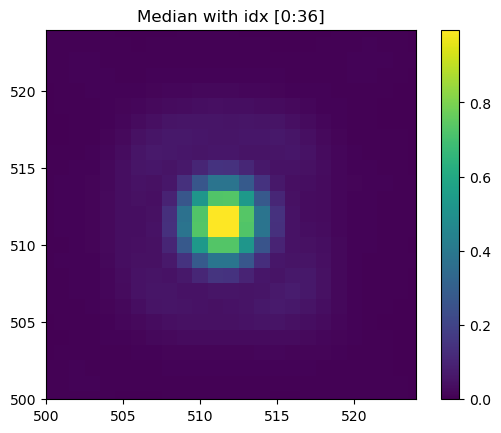

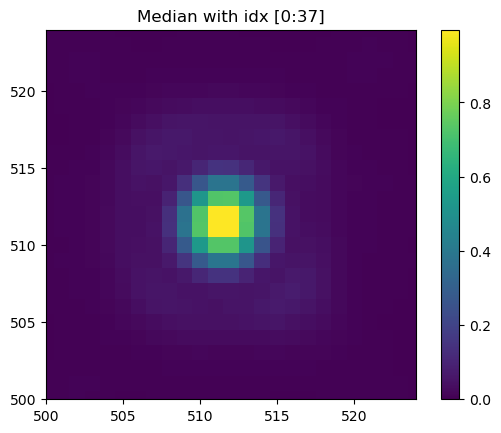

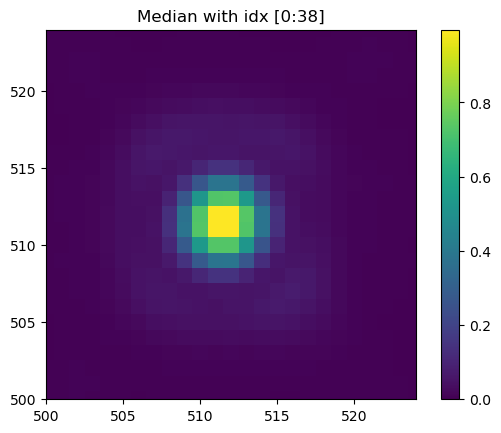

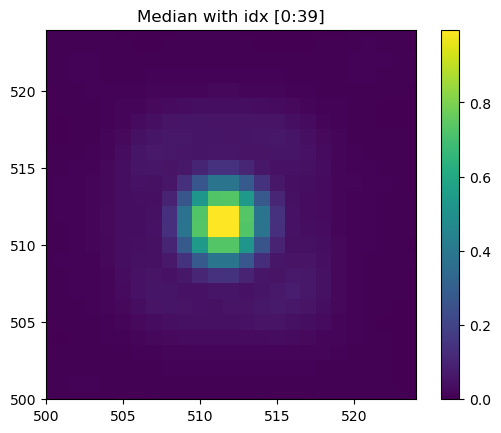

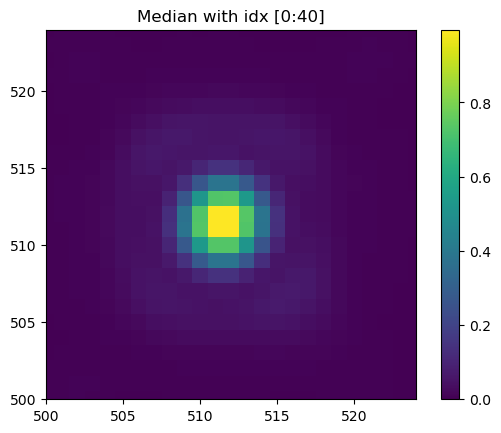

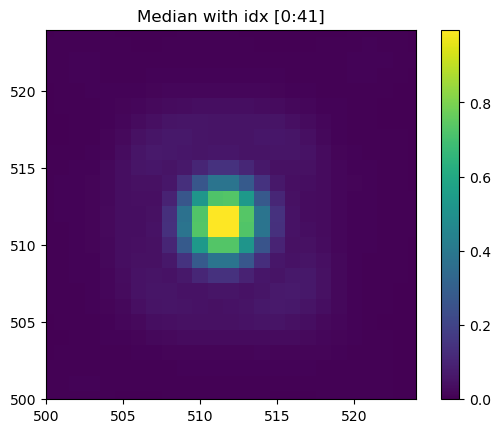

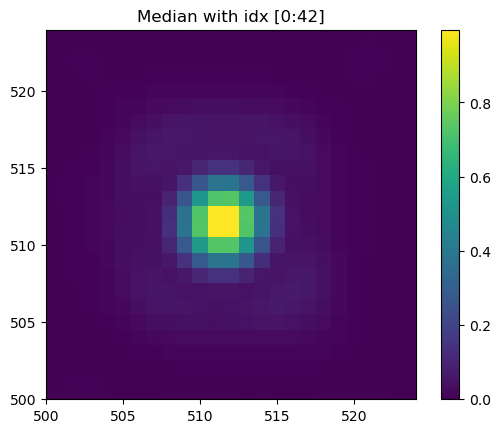

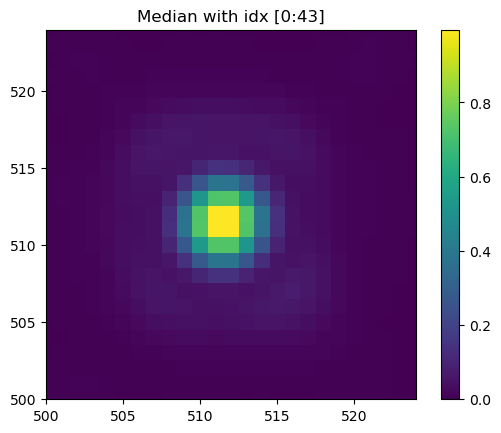

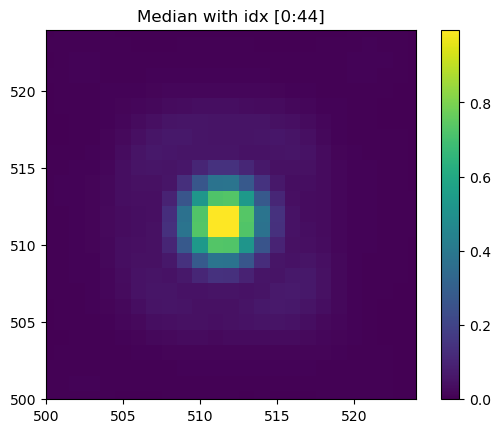

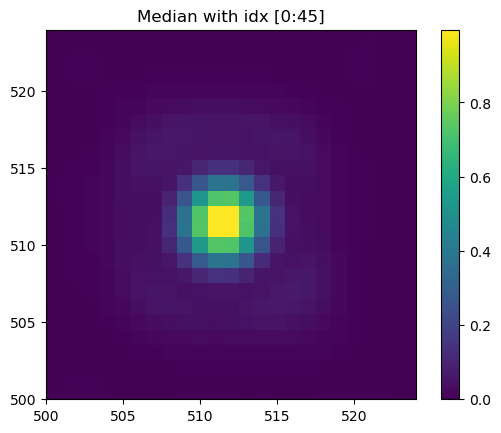

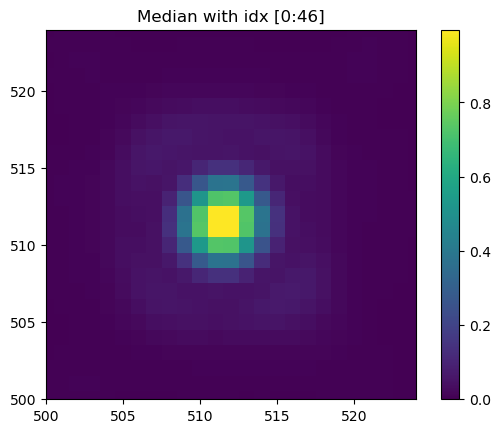

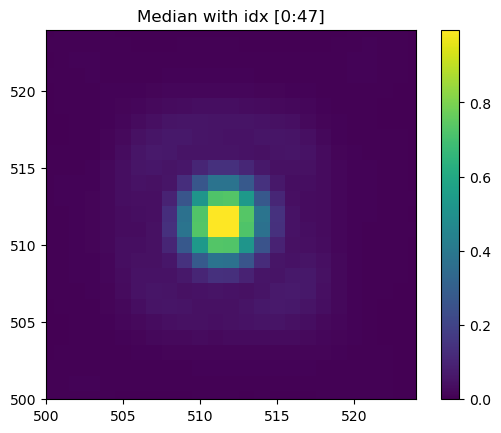

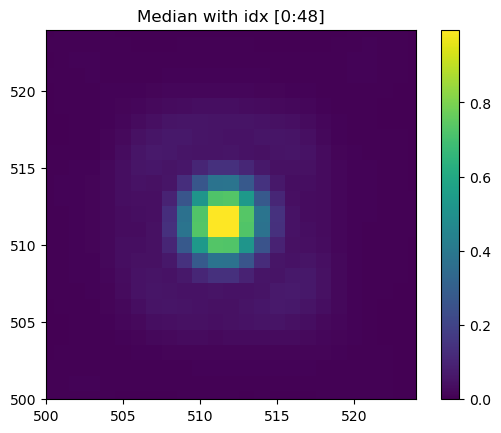

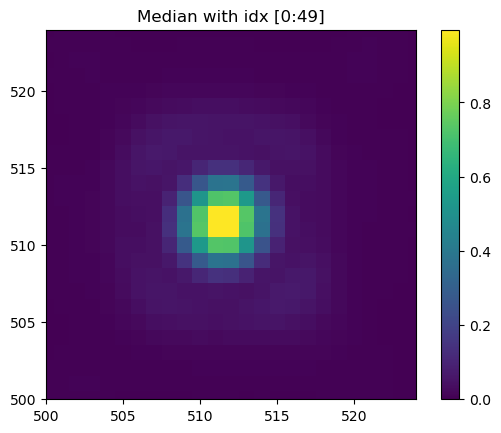

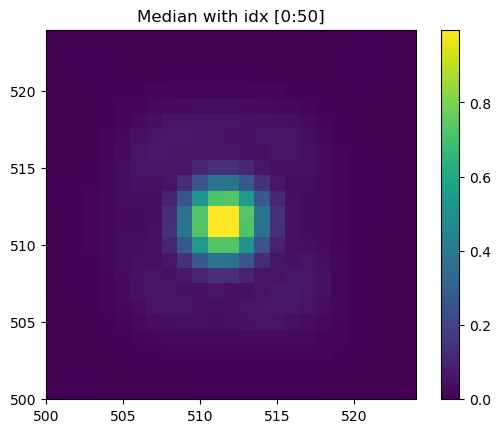

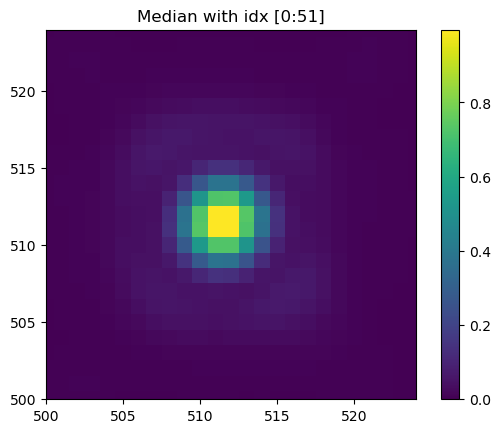

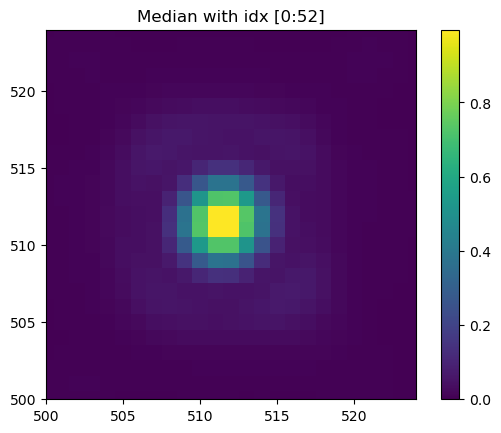

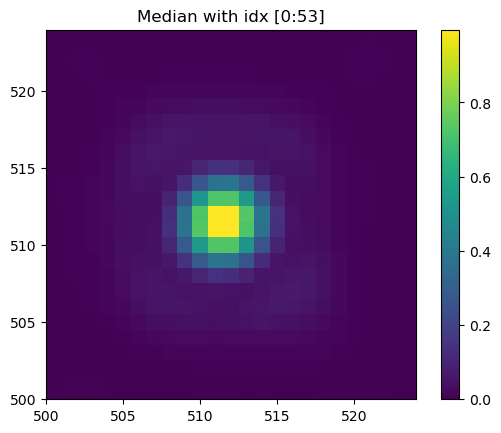

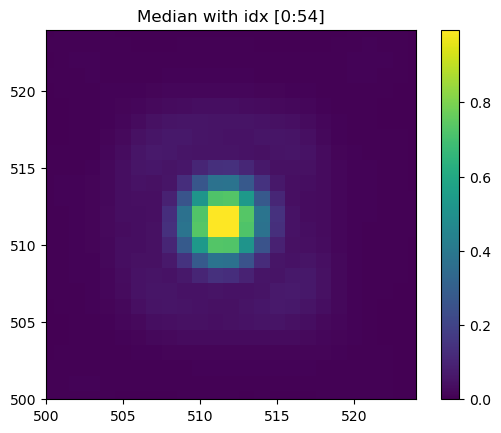

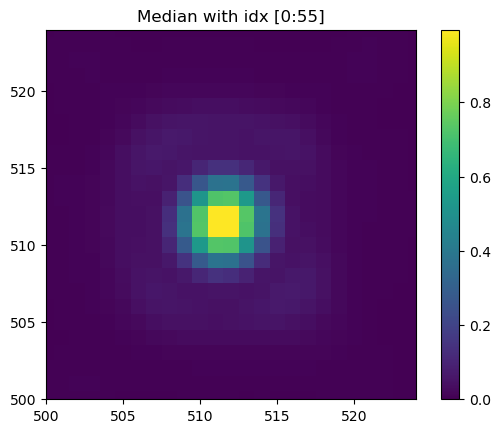

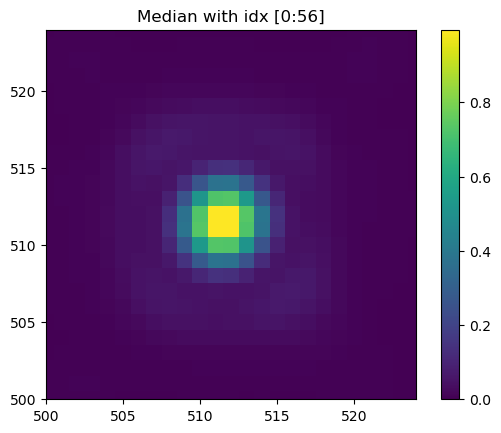

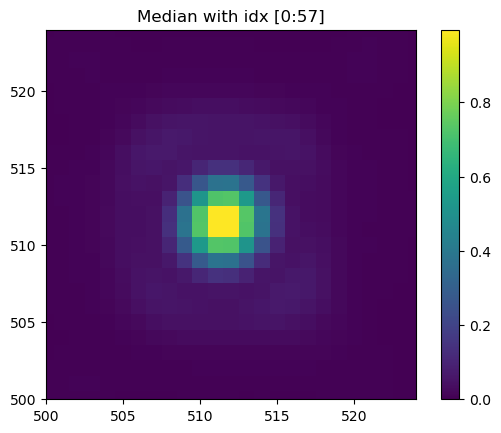

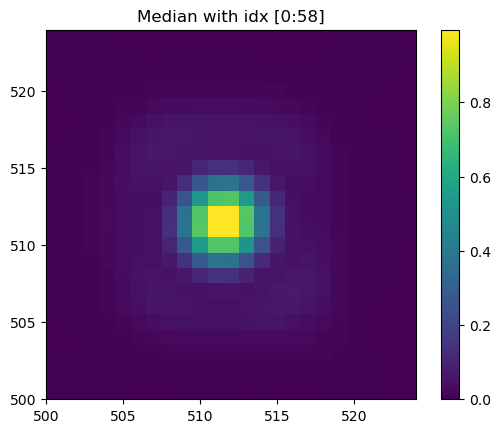

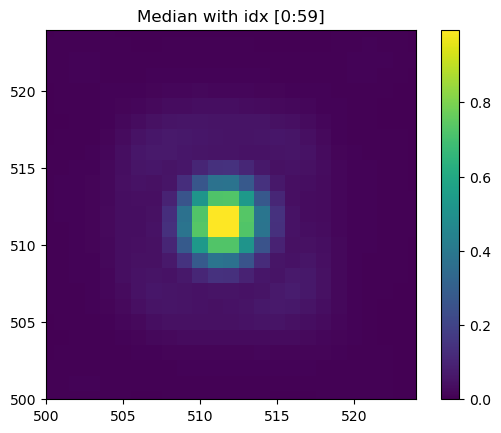

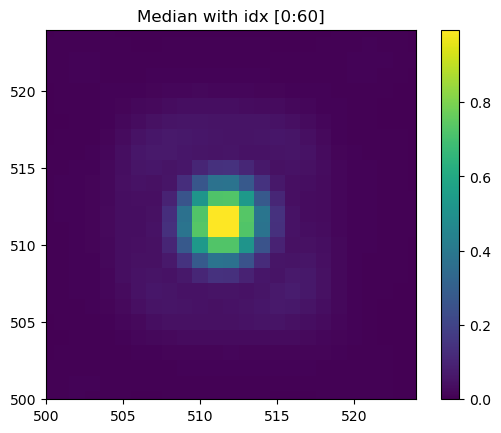

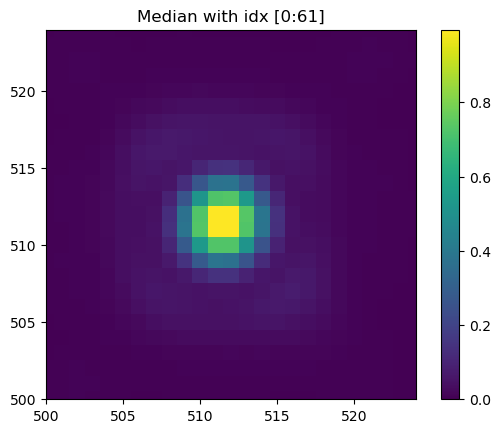

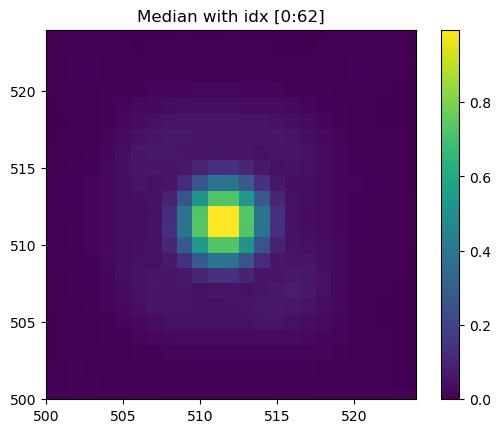

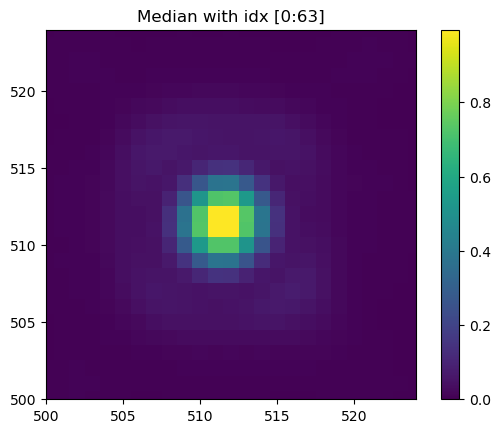

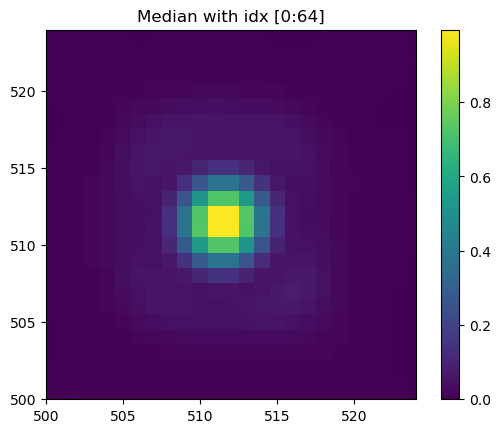

In [240]:
rms_arr = np.empty_like(rms_s_s, dtype = float)
for i in range(len(rms_s_s)):
    idx_arr = rms_s_idx[0:i+1]
    med = median_star_arr(single_stars[idx_arr])
    rms_arr[i] = rms_patch(med)
    plt.figure()
    plt.title(f'Median with idx [0:{i+1}]')
    plt.imshow(med)
    plt.gca().invert_yaxis()
    plt.xlim(500, 524)
    plt.ylim(500, 524)
    plt.colorbar()
    plt.show()

In [1]:
plt.figure()
plt.plot(N_keep, rms_arr)
plt.xlabel('Numbers of images used for median')
plt.ylabel('RMS of median image')
plt.show()

NameError: name 'plt' is not defined

In [238]:
np.argmin(rms_arr)

53

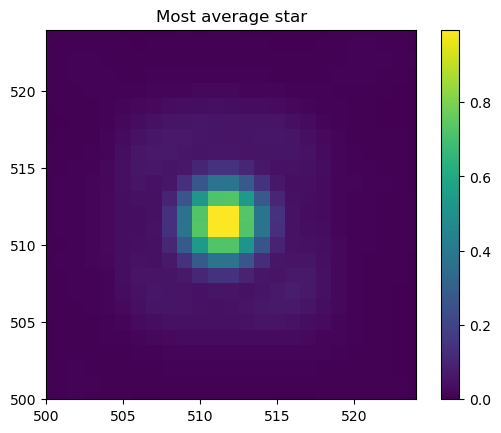

In [22]:
plt.imshow(med_arr)
plt.title('Most average star')
plt.gca().invert_yaxis()
plt.xlim(500, 524)
plt.ylim(500, 524)
plt.colorbar()
plt.show()

# 5. Subtract median star from test stars

In [23]:
def subtract_star(im, med_st):
    ''' Subtract the median star from the image and images the results'''
    im = calibration(im, 100)
    dx = im - med_st
    return dx

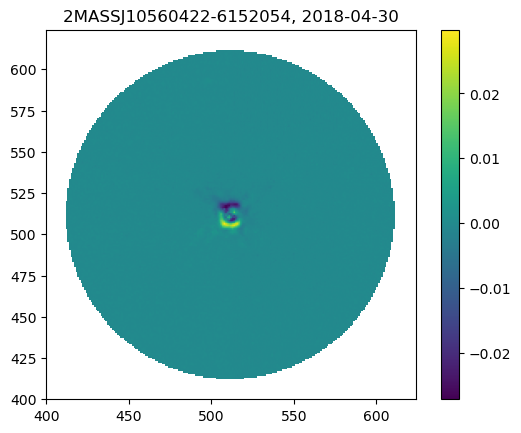

In [24]:
rest = subtract_star(star_data(0, single_stars), med_arr)
name, date = star_info(0, single_stars)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(400, 624)
plt.ylim(400, 624)
plt.show()

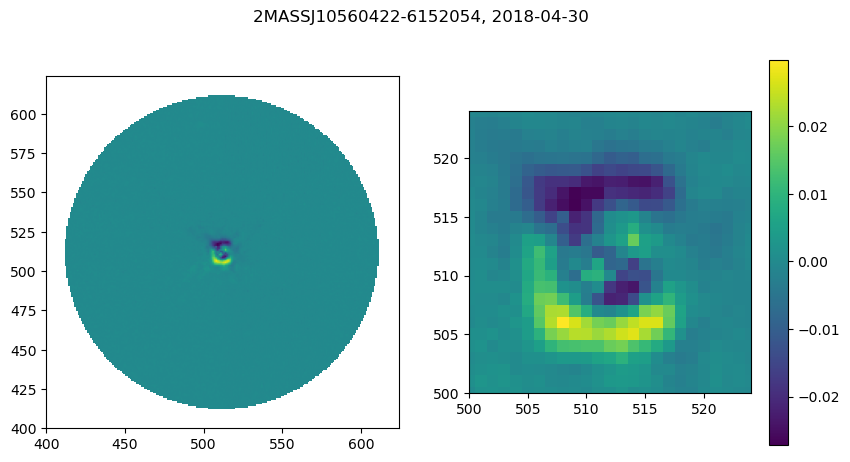

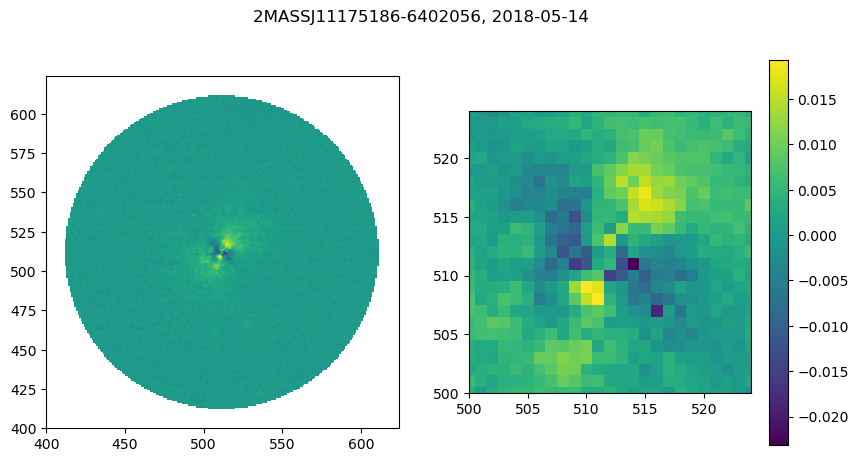

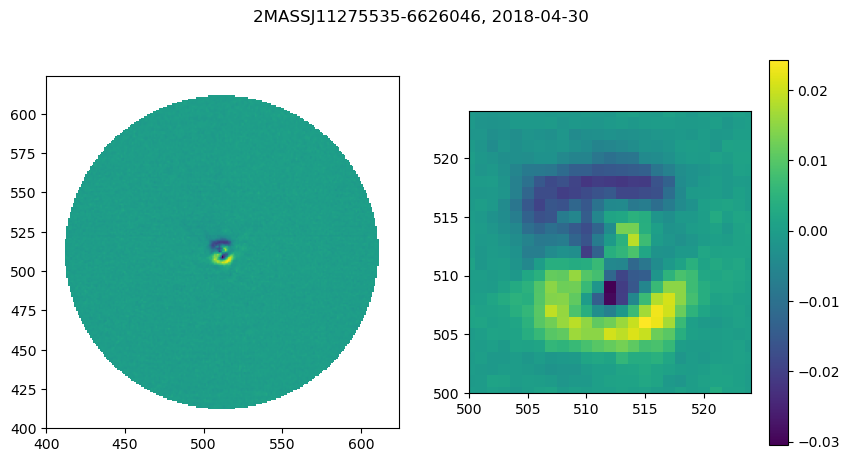

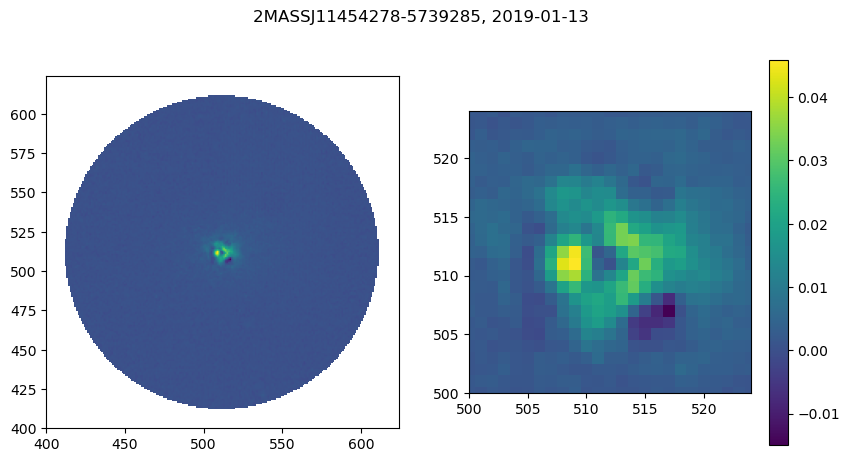

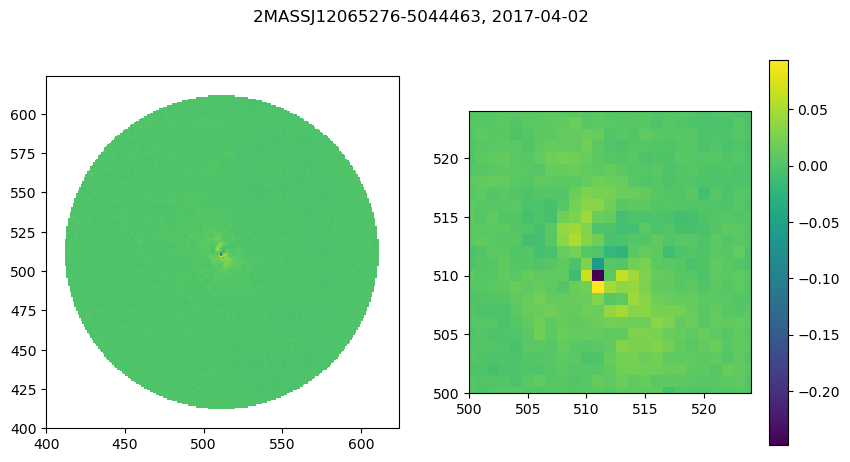

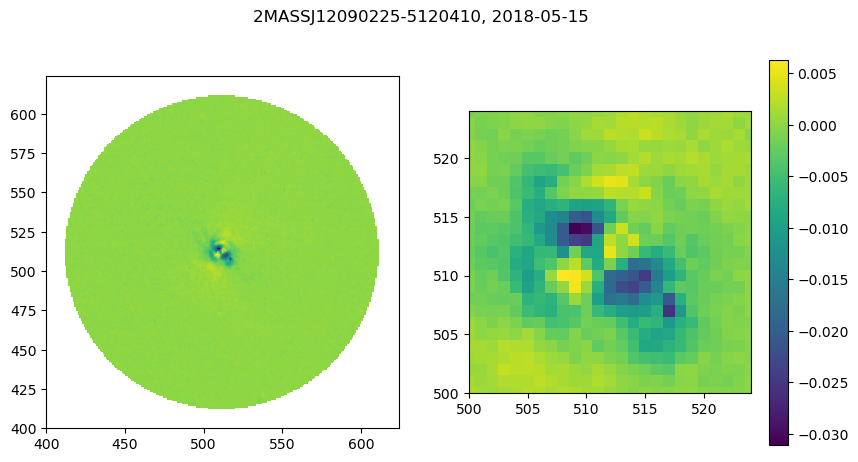

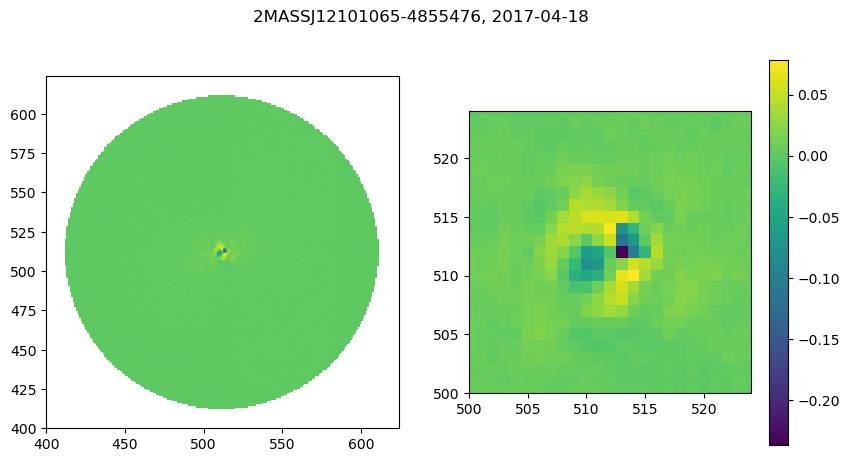

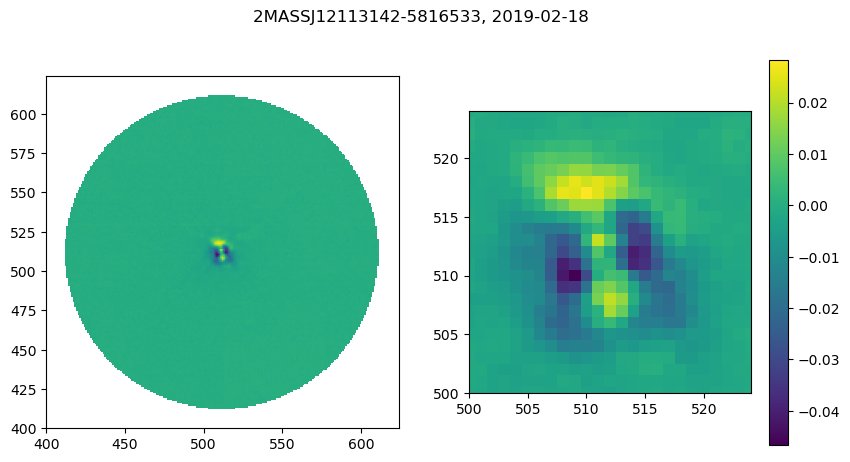

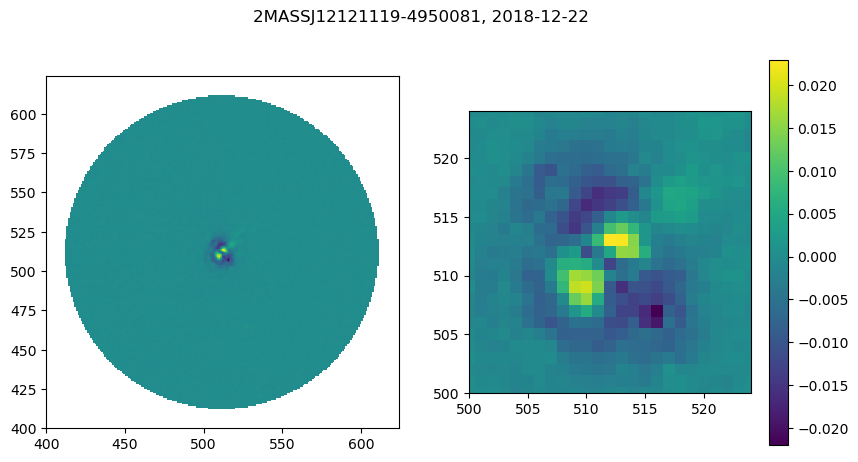

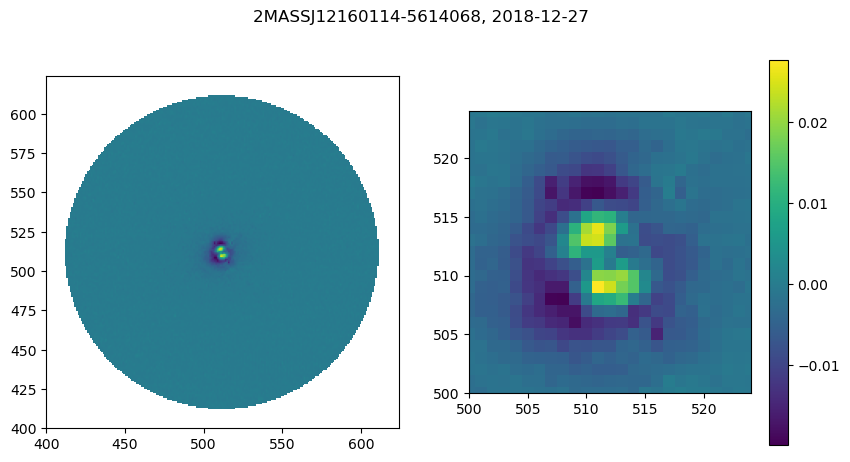

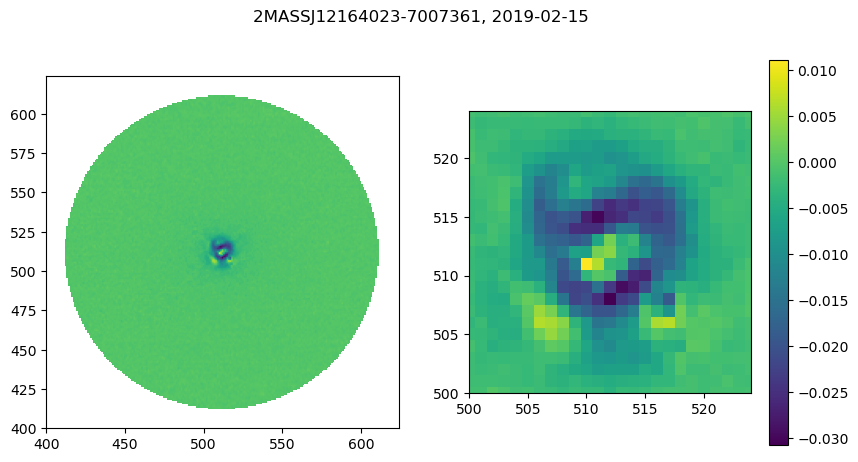

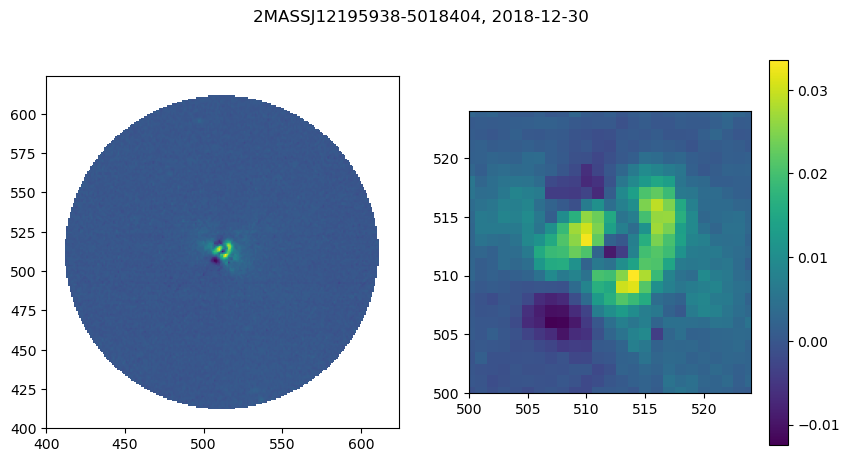

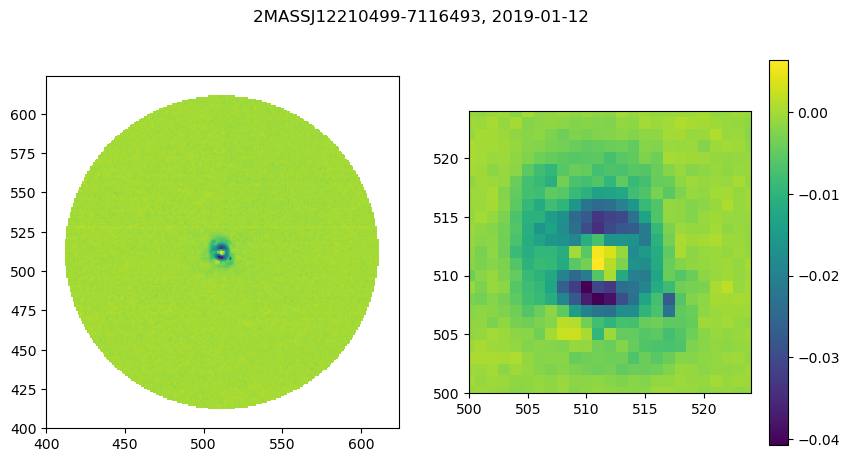

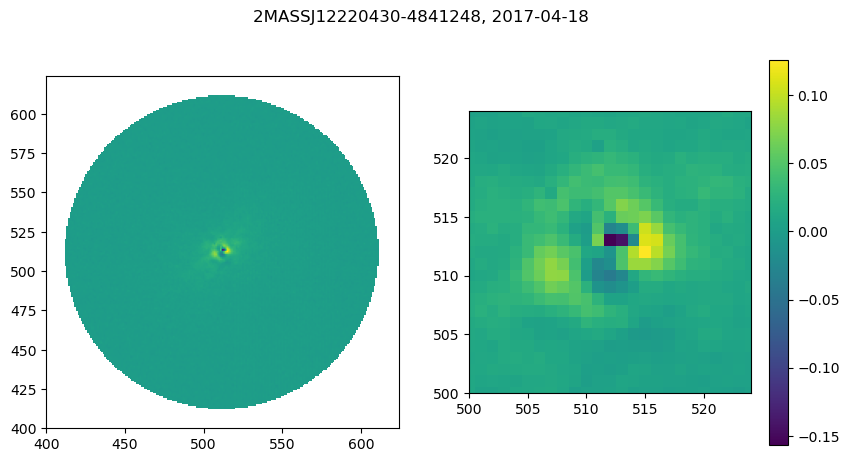

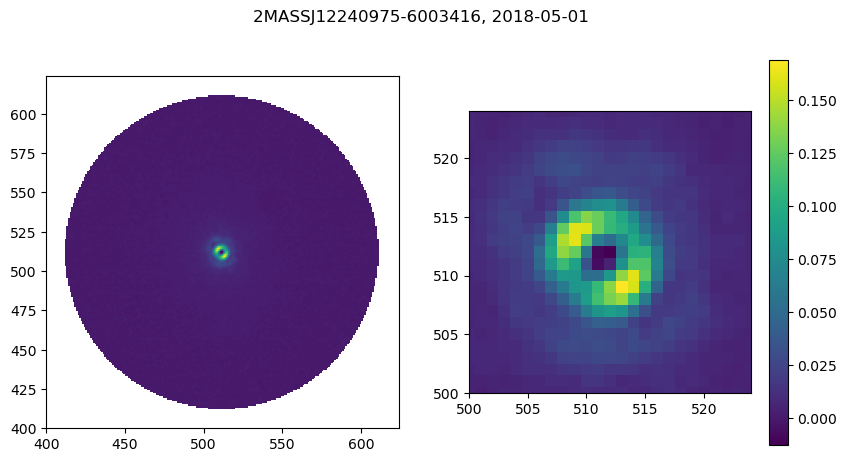

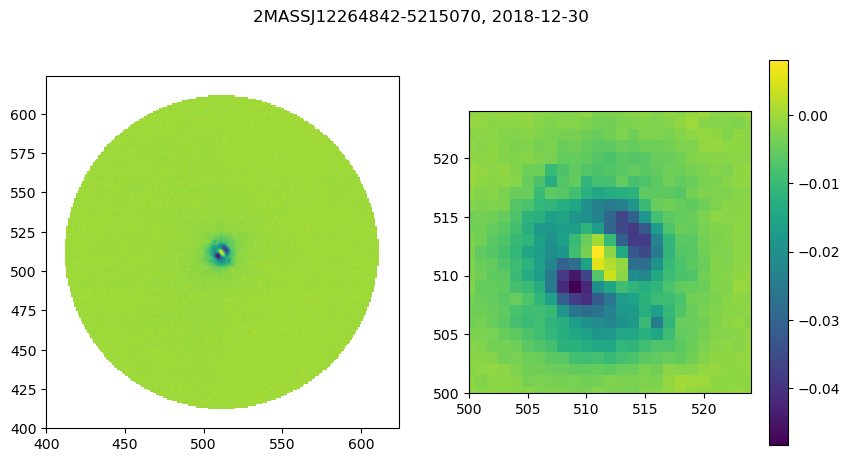

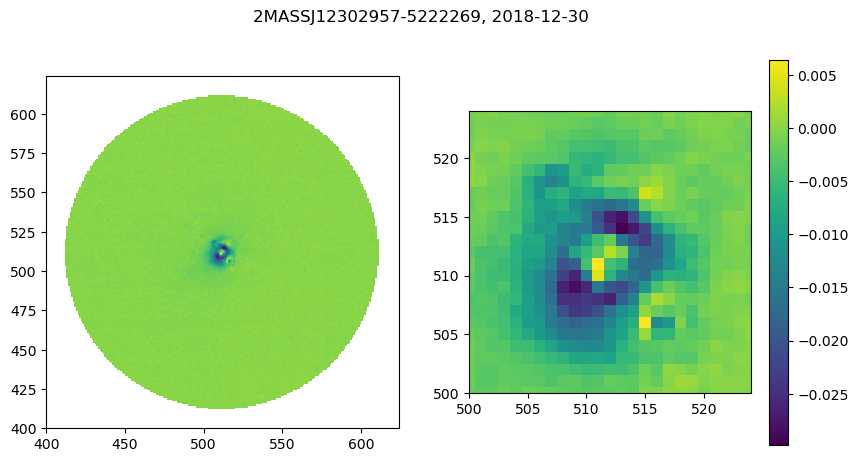

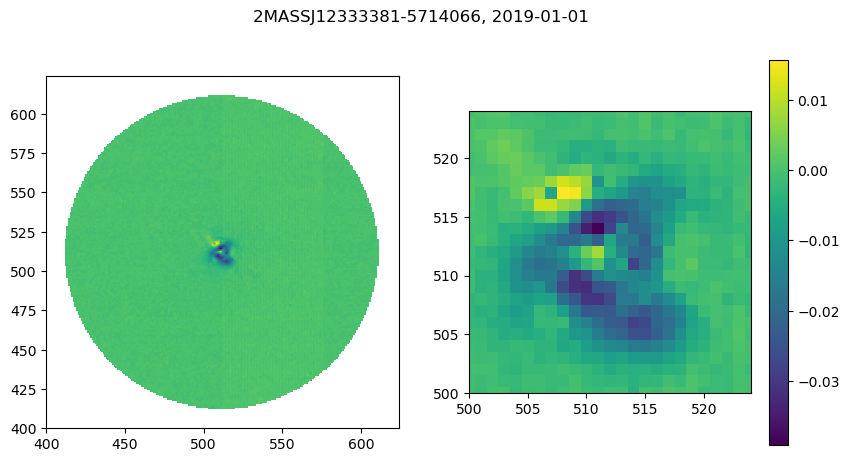

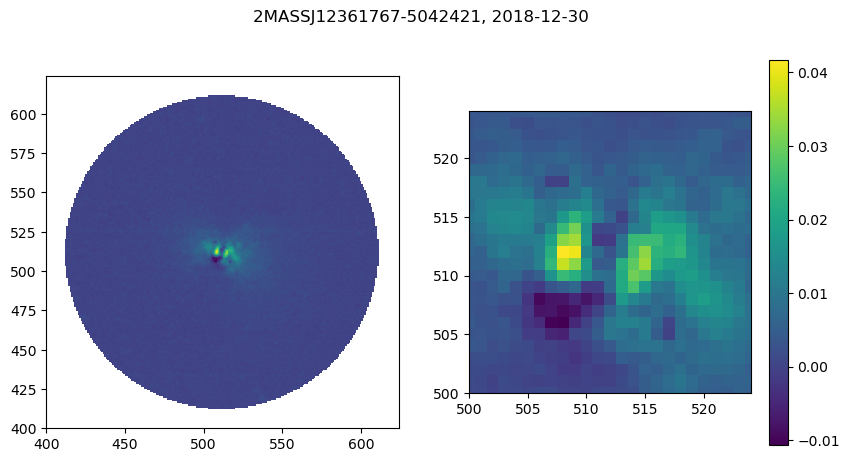

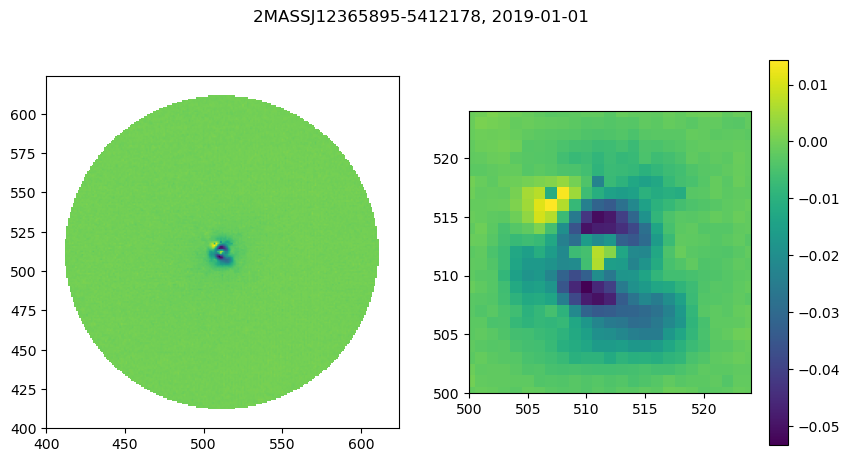

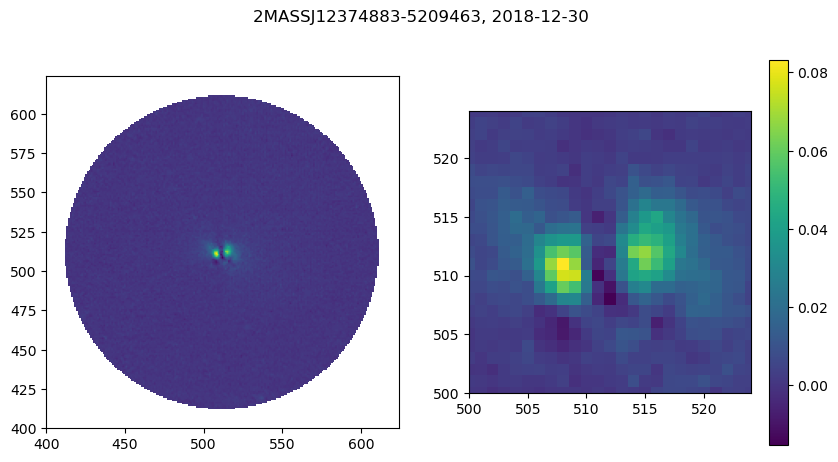

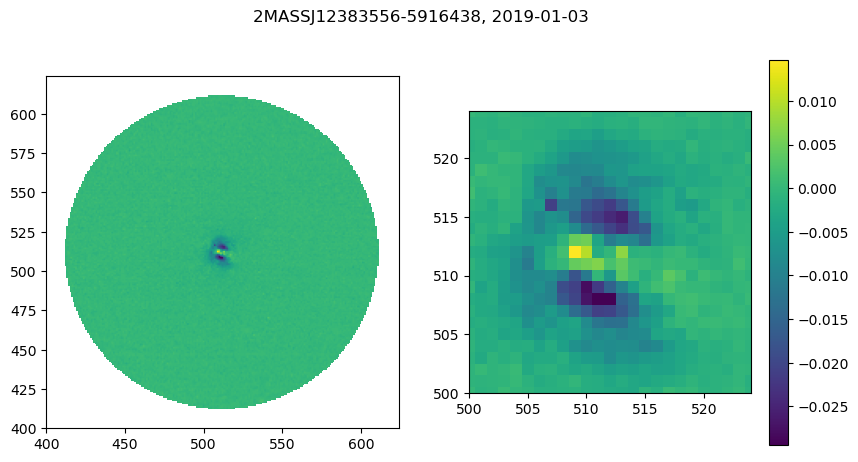

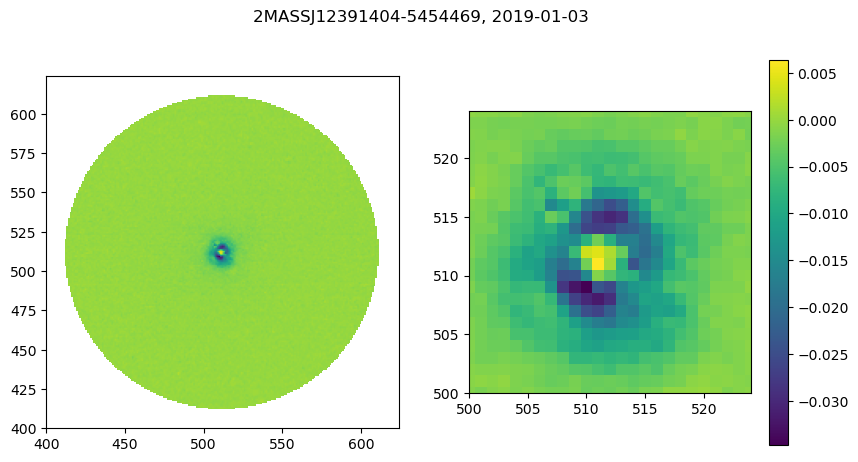

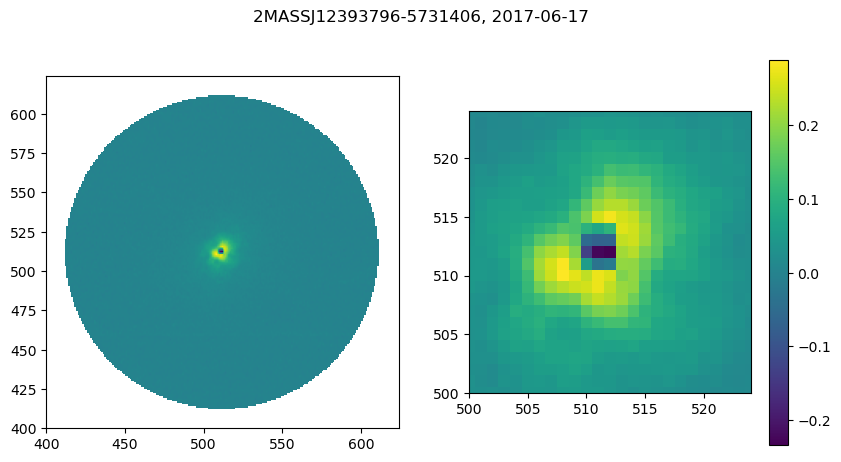

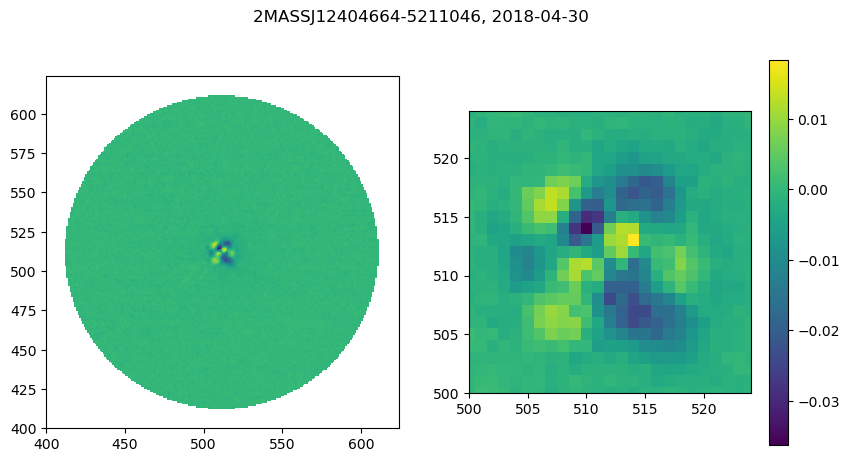

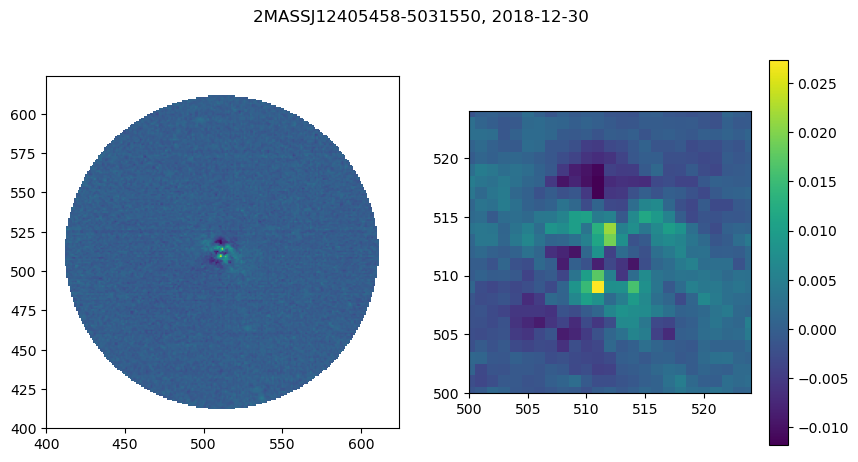

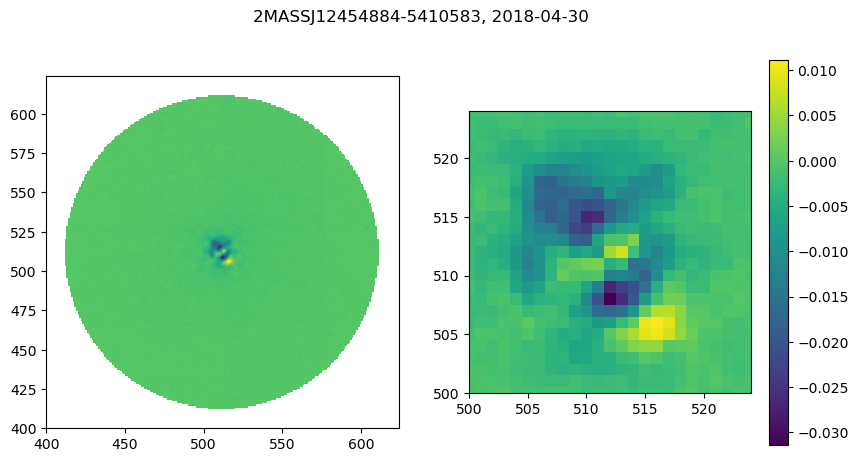

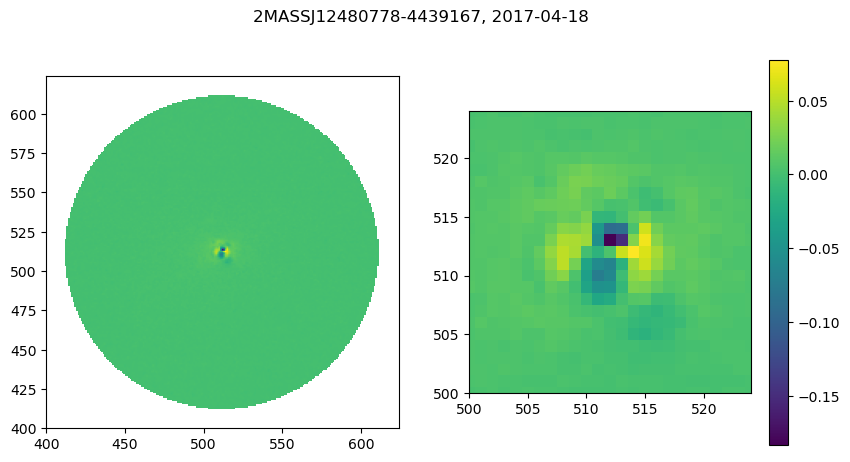

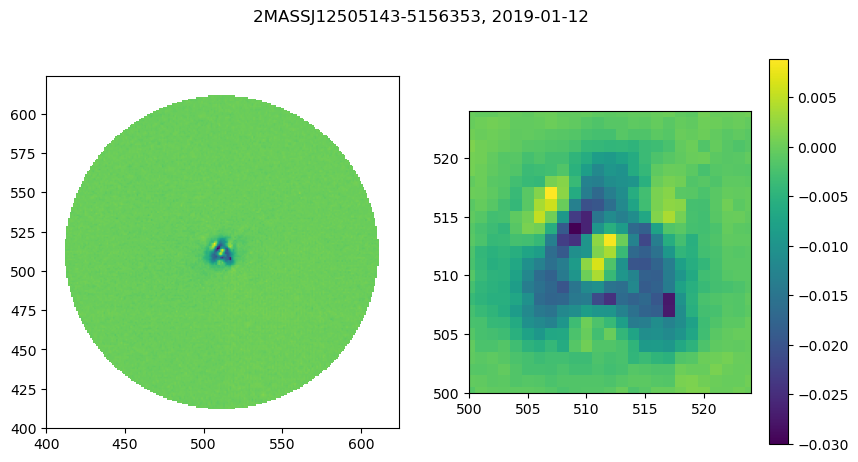

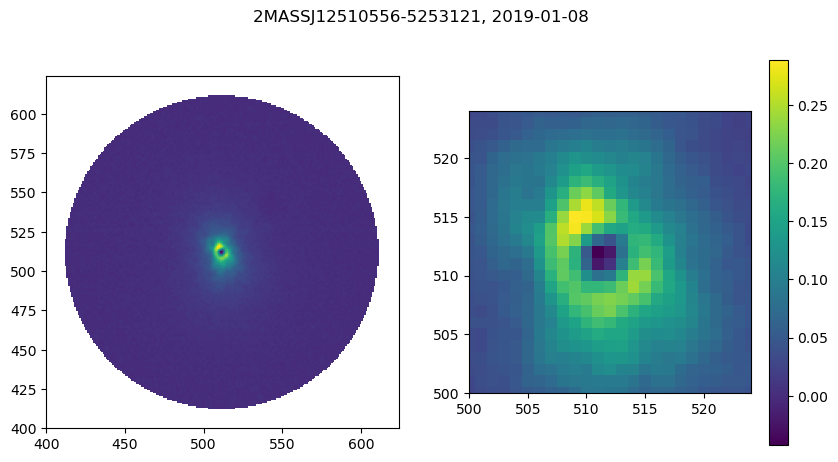

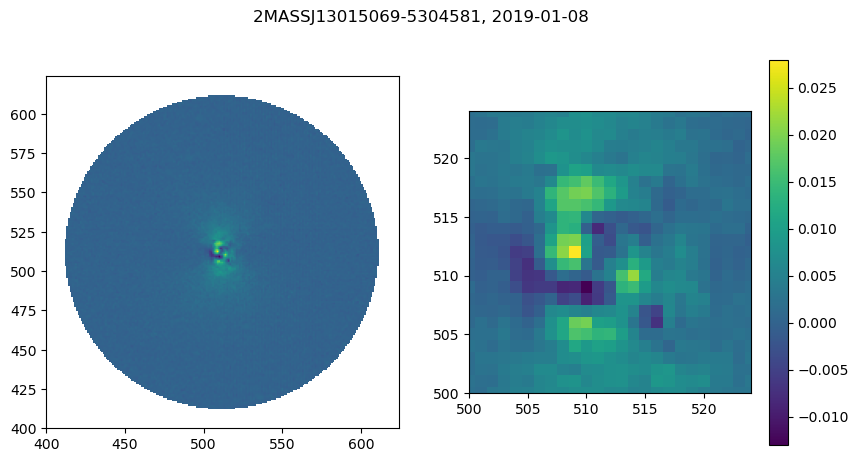

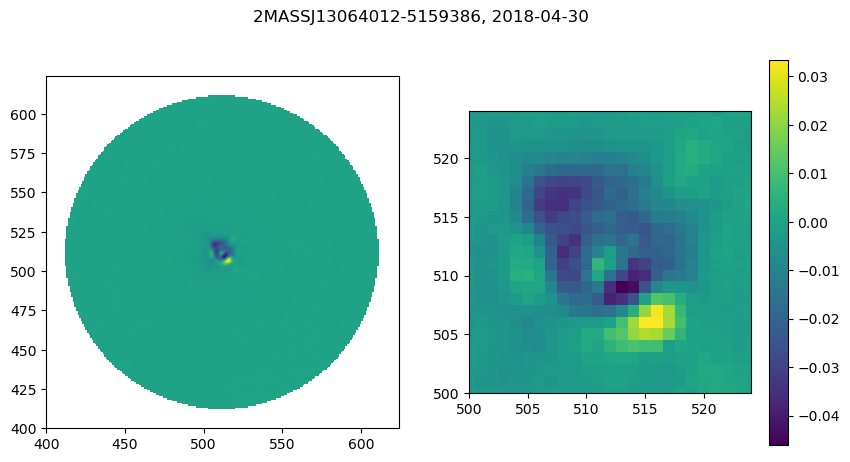

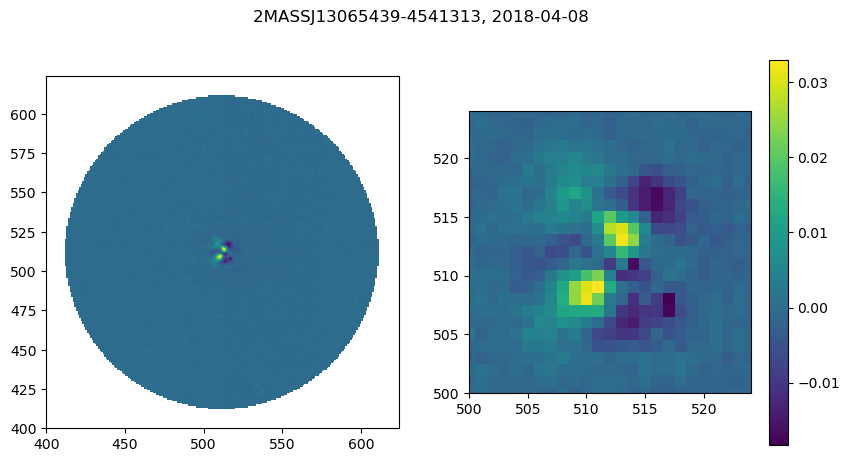

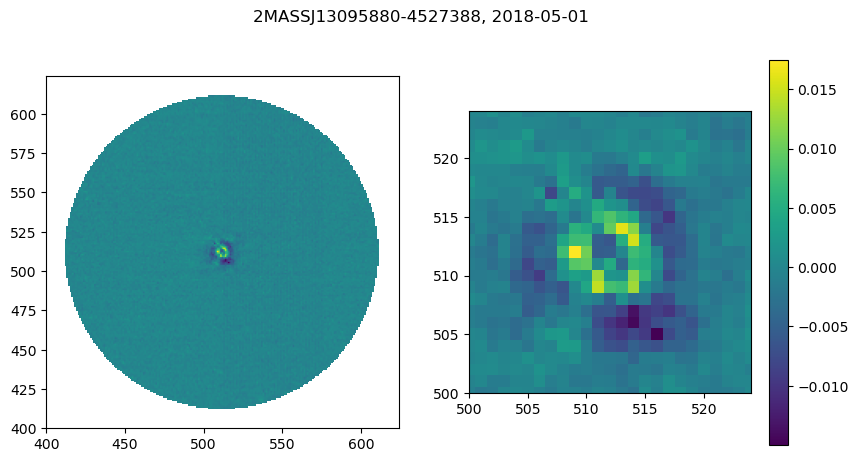

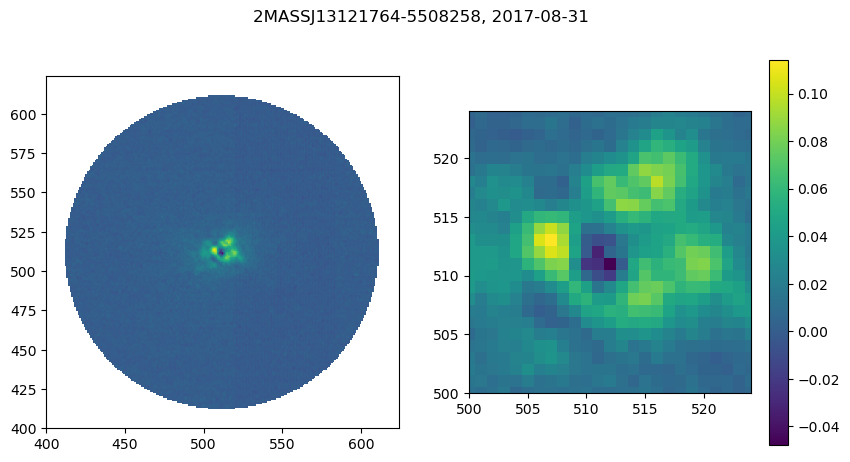

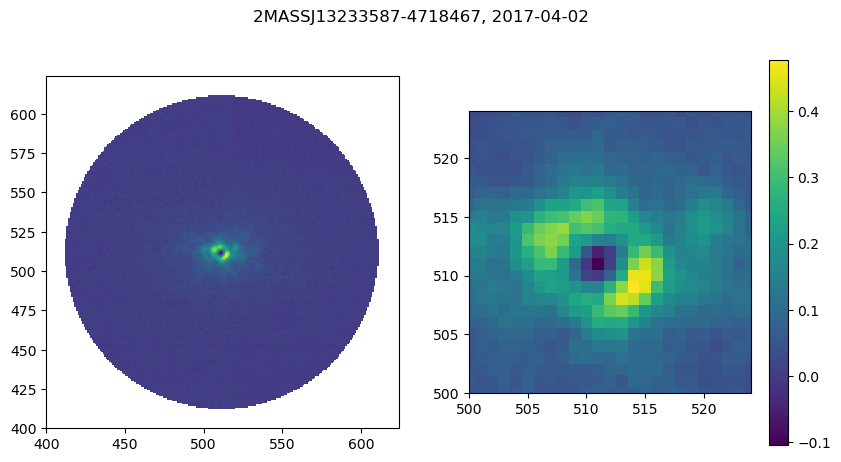

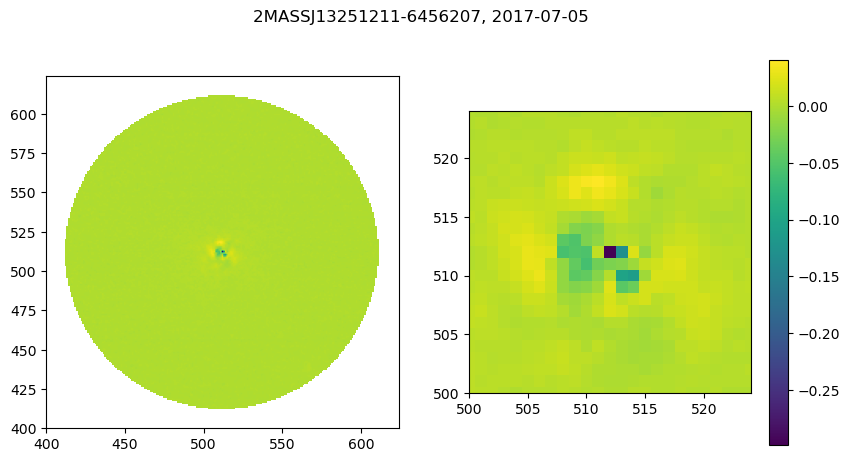

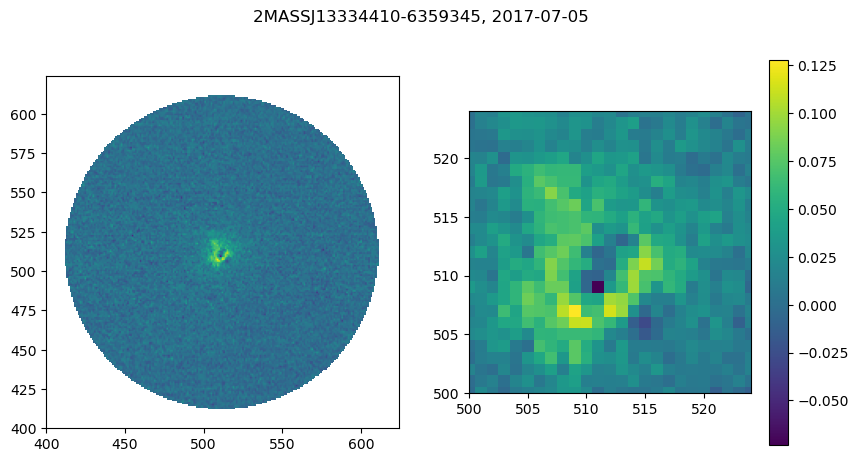

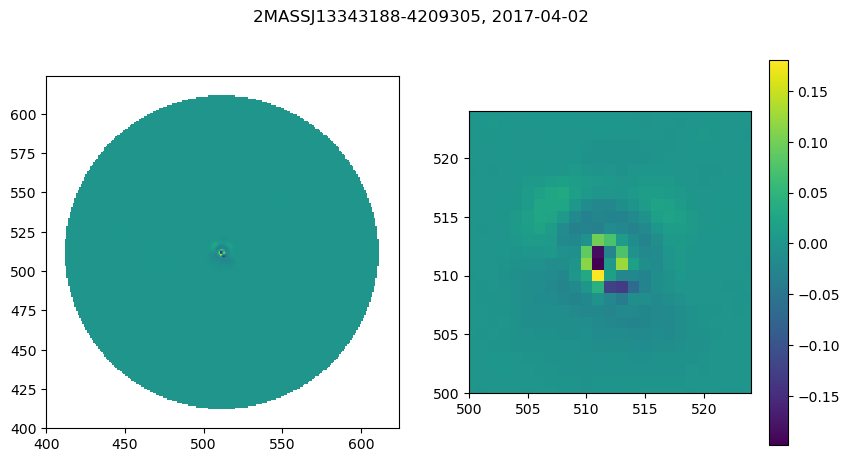

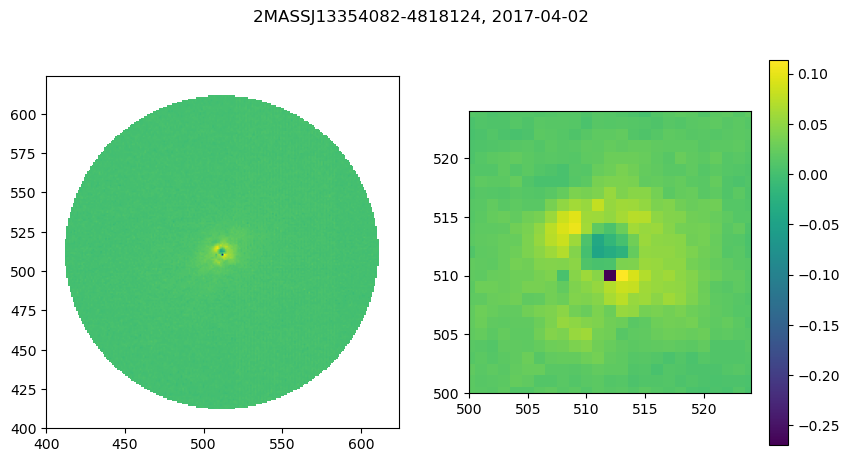

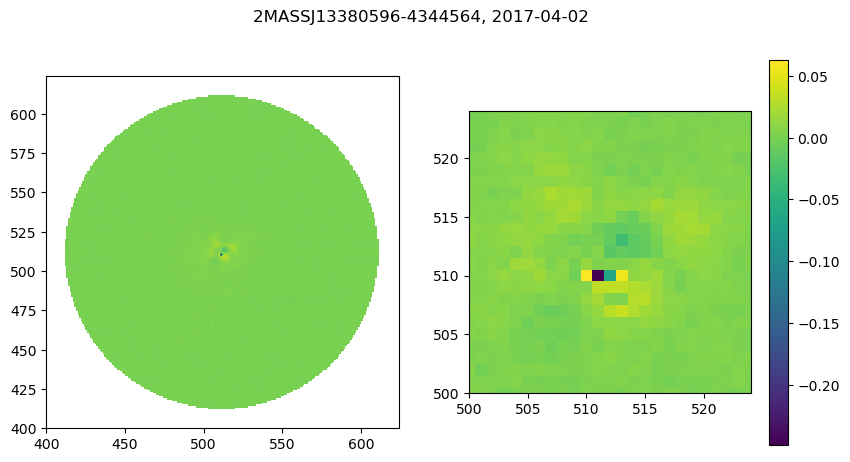

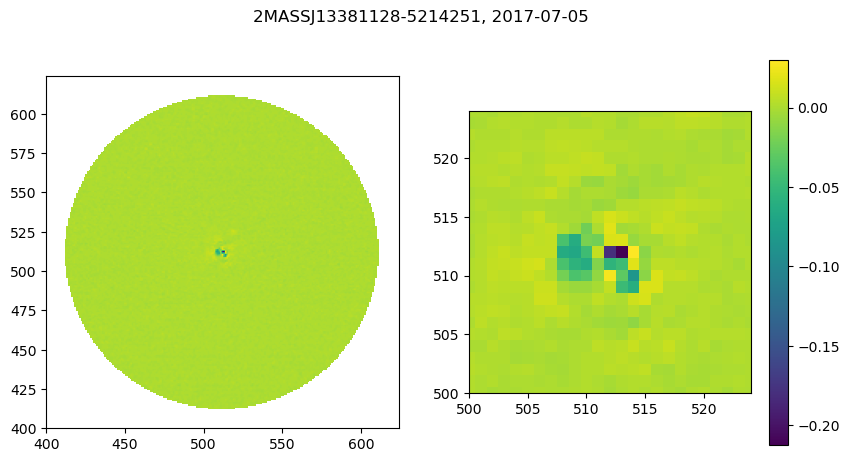

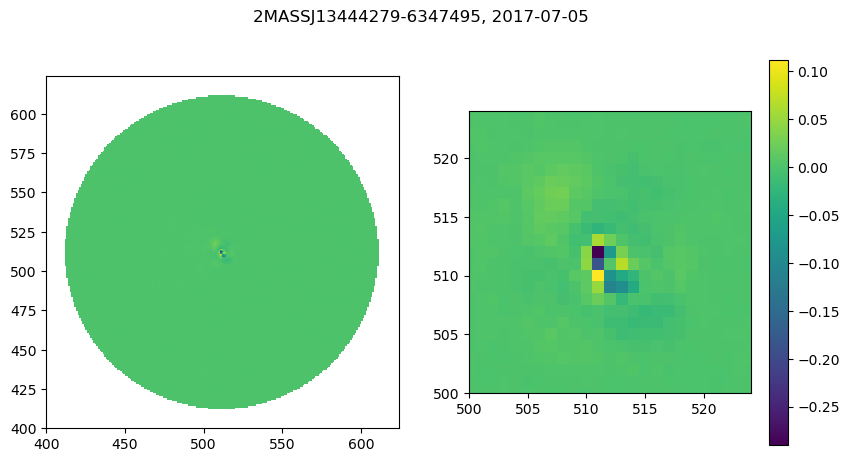

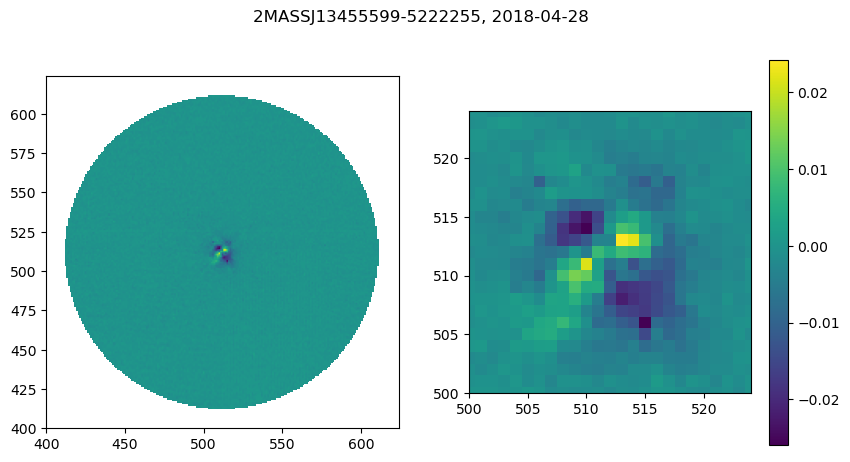

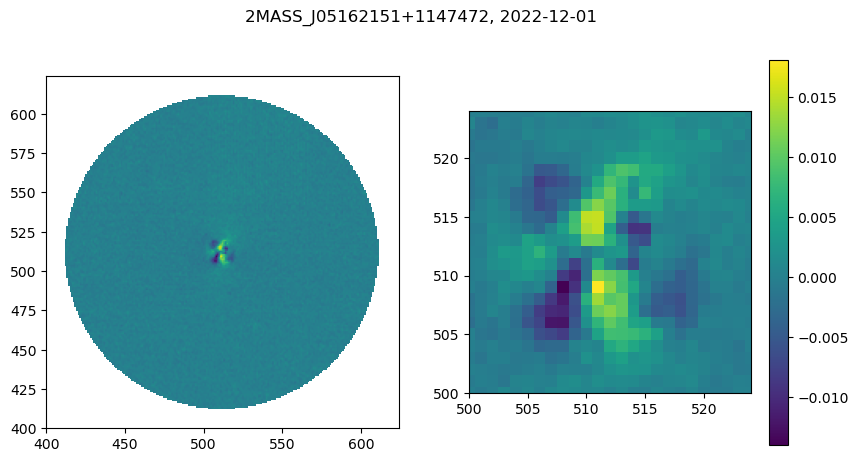

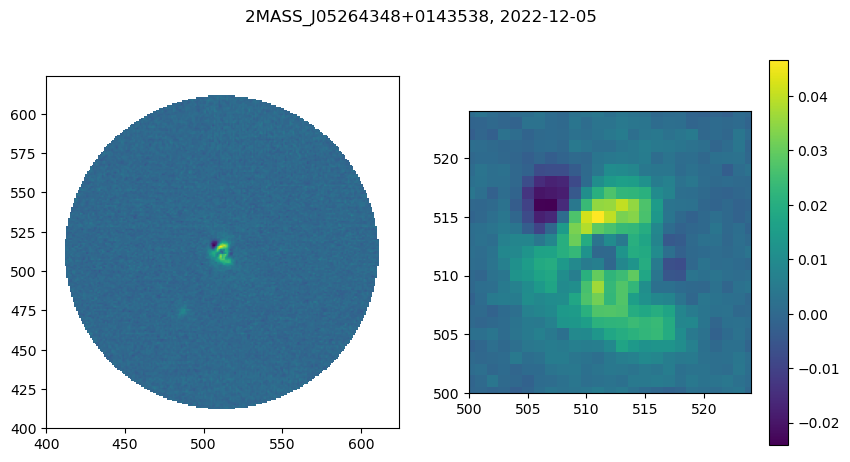

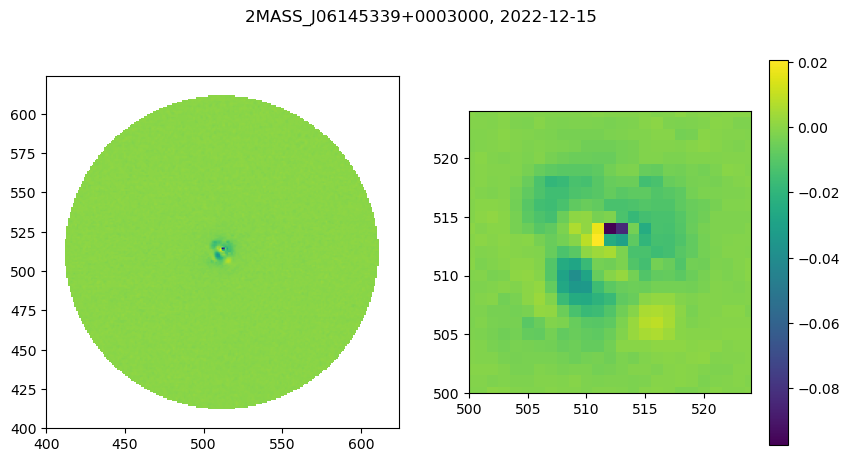

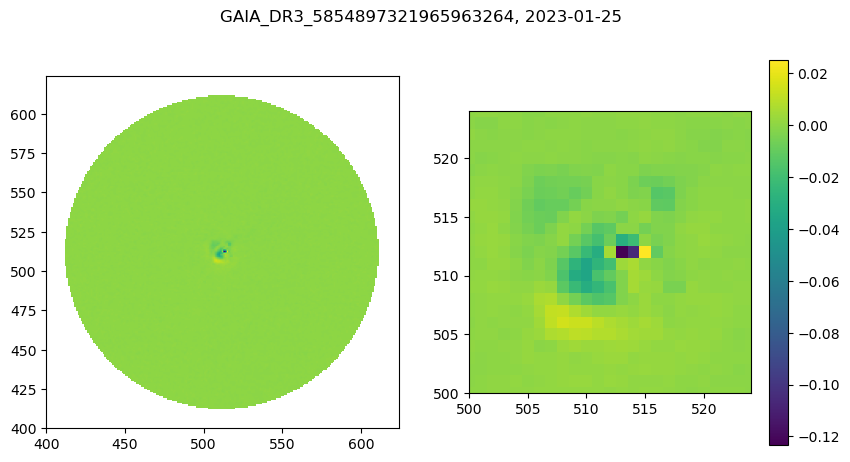

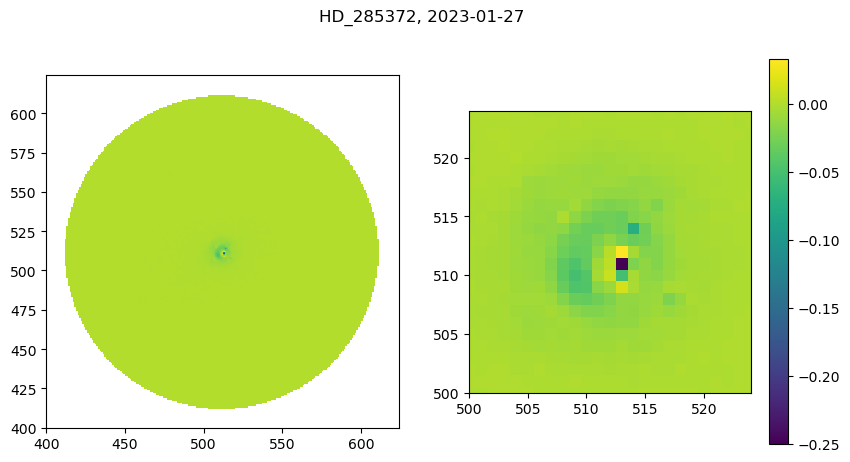

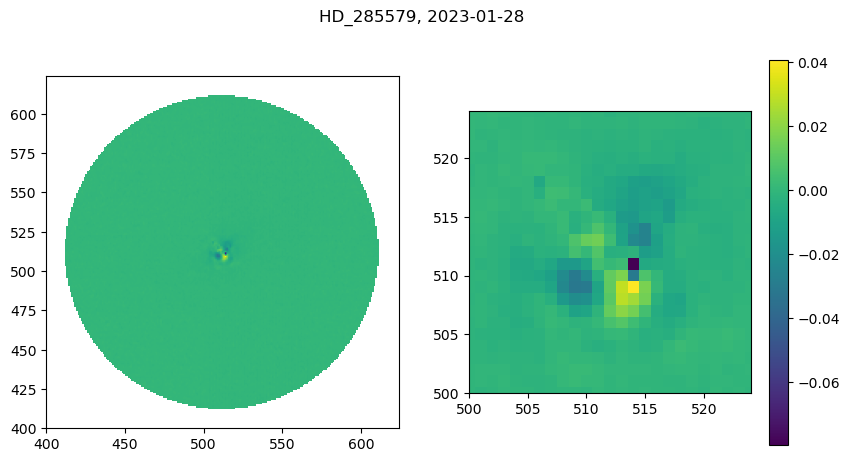

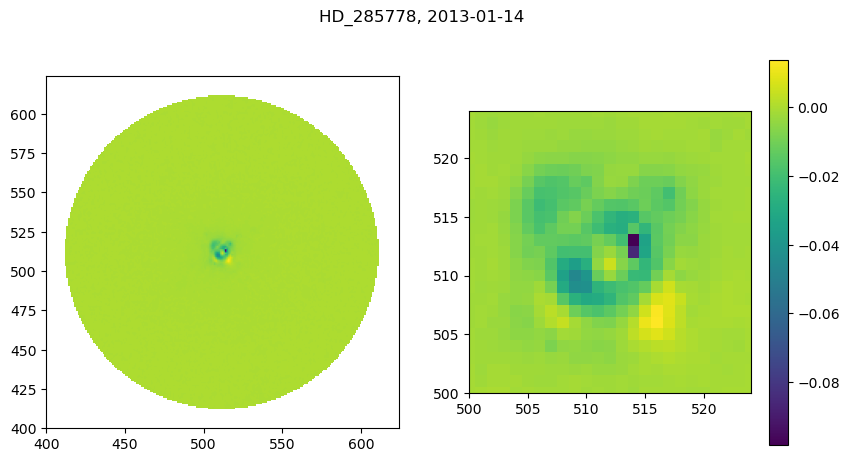

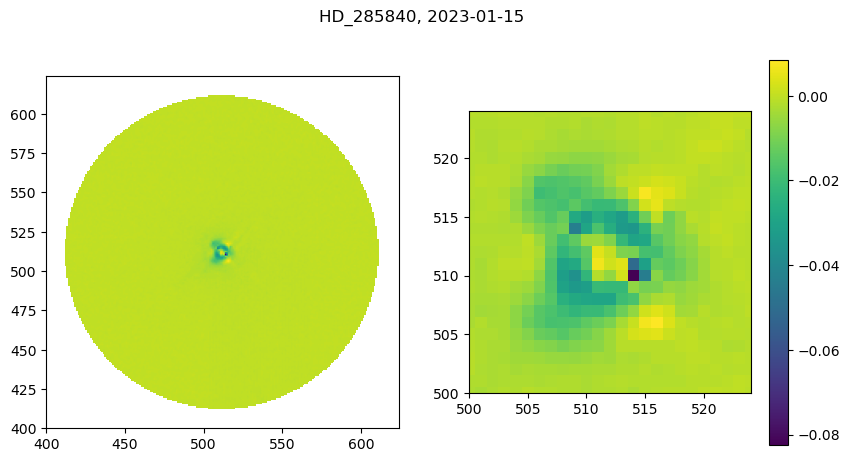

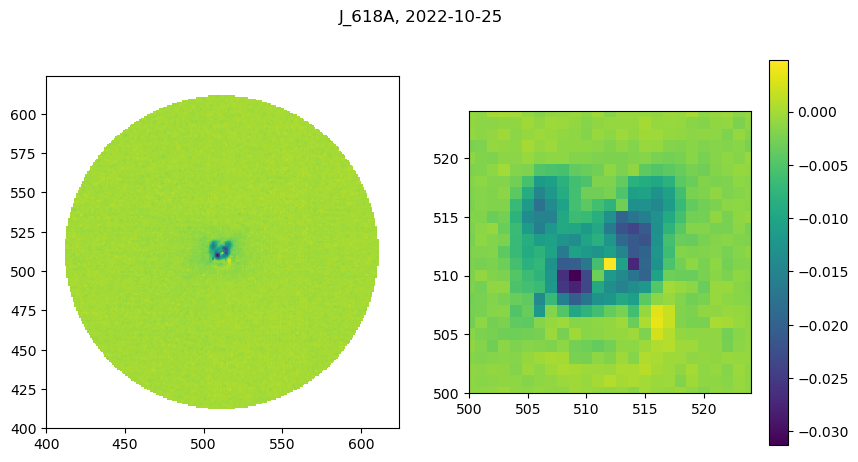

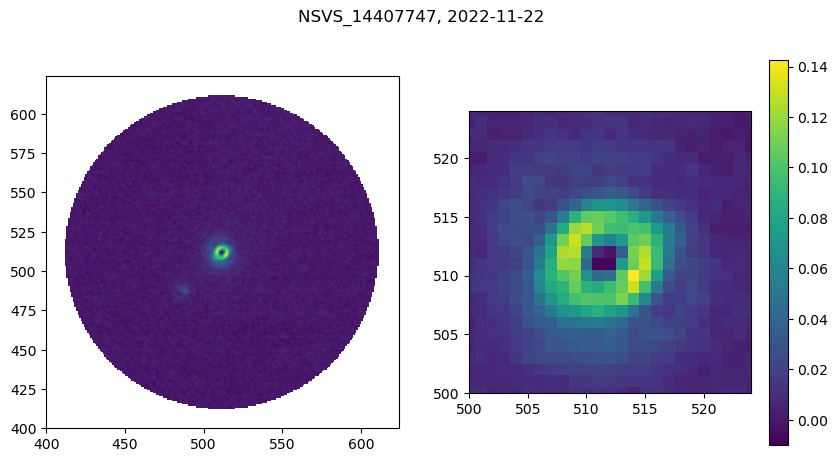

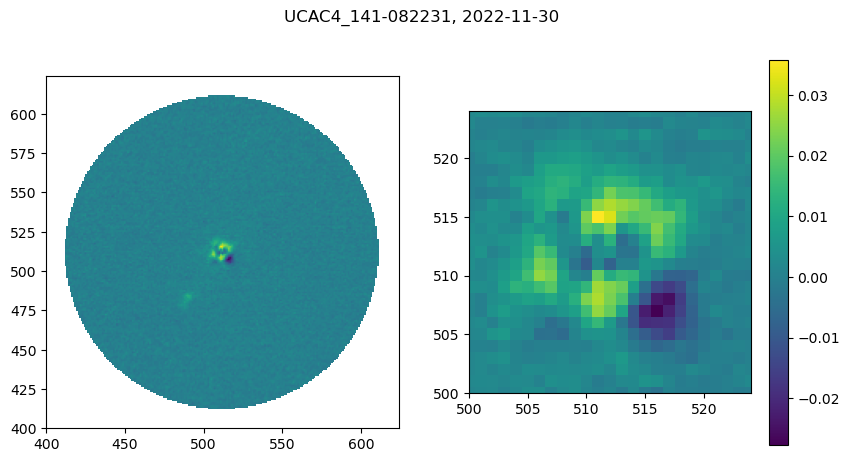

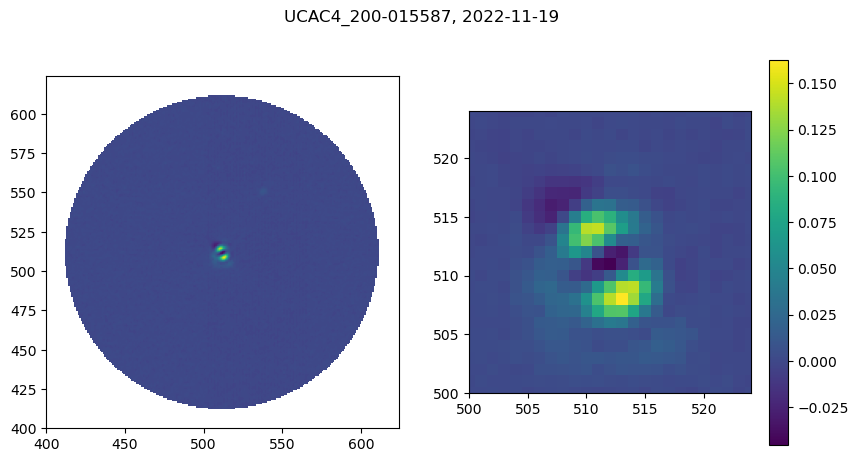

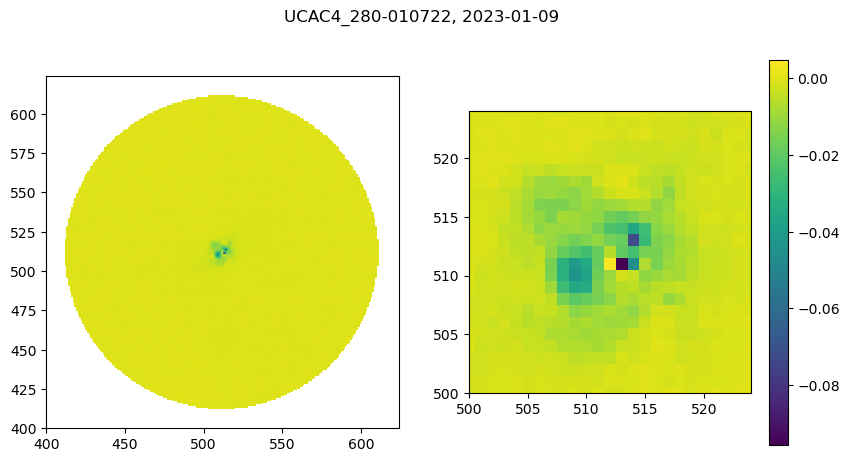

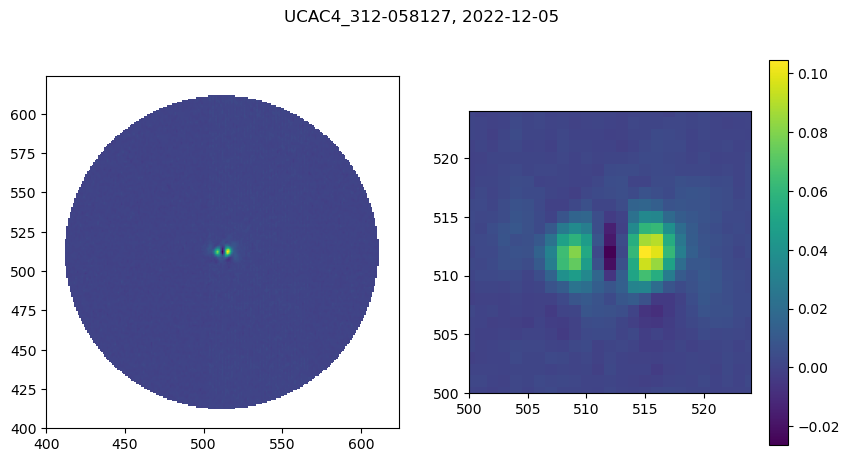

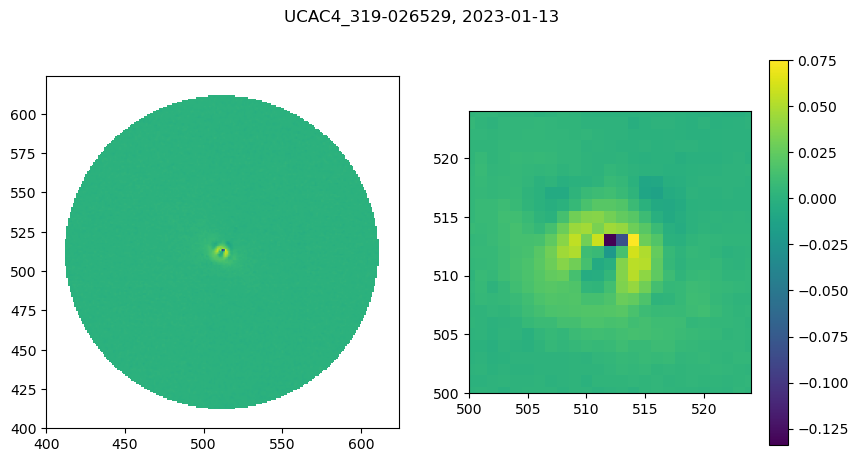

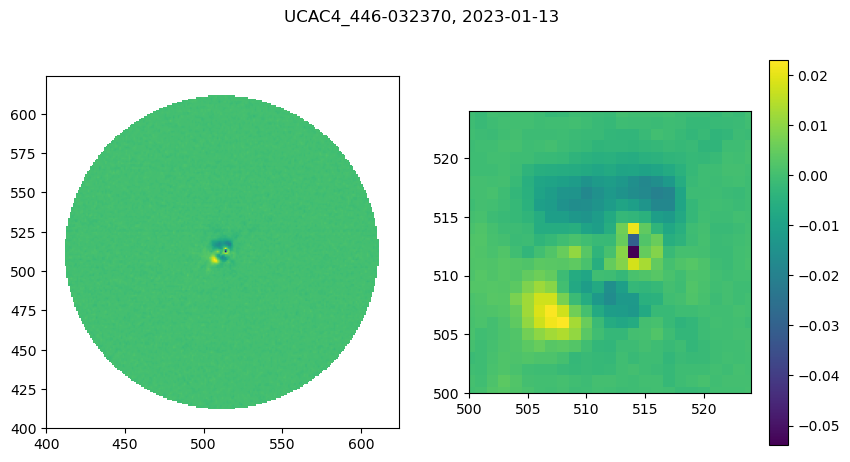

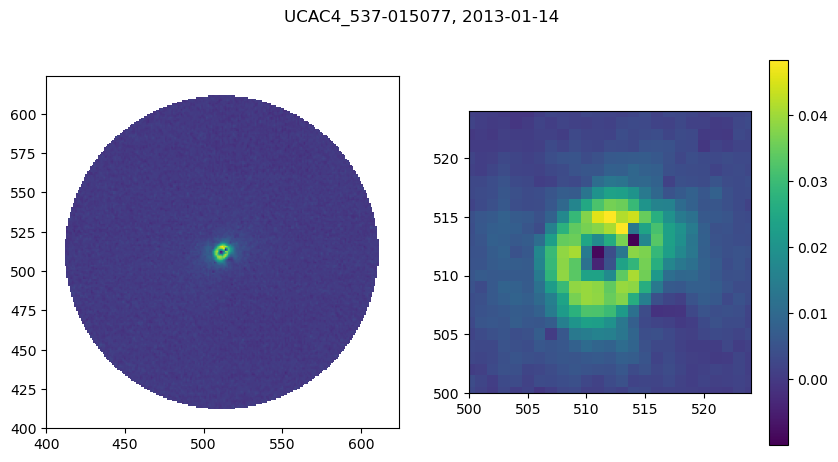

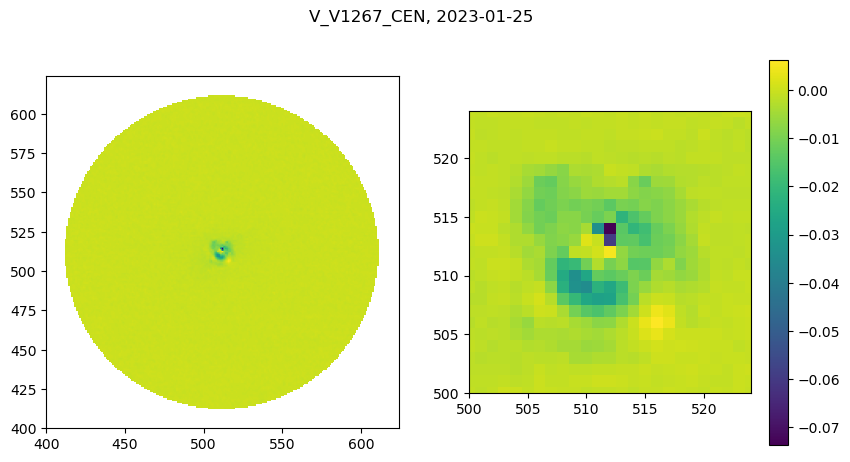

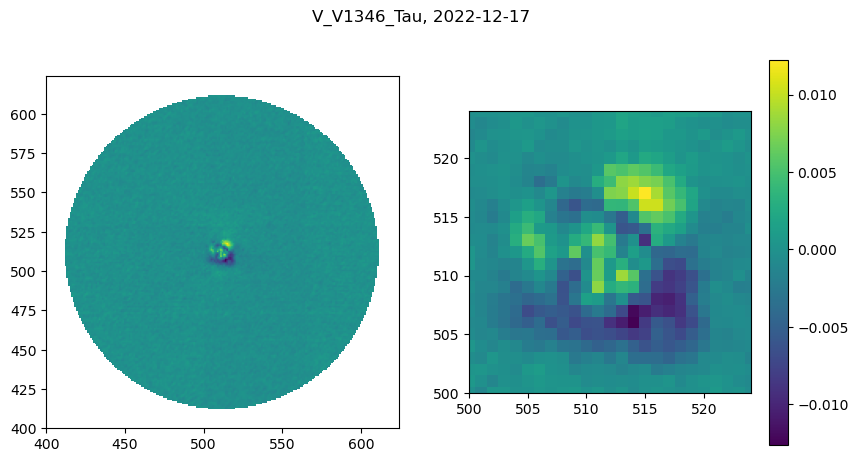

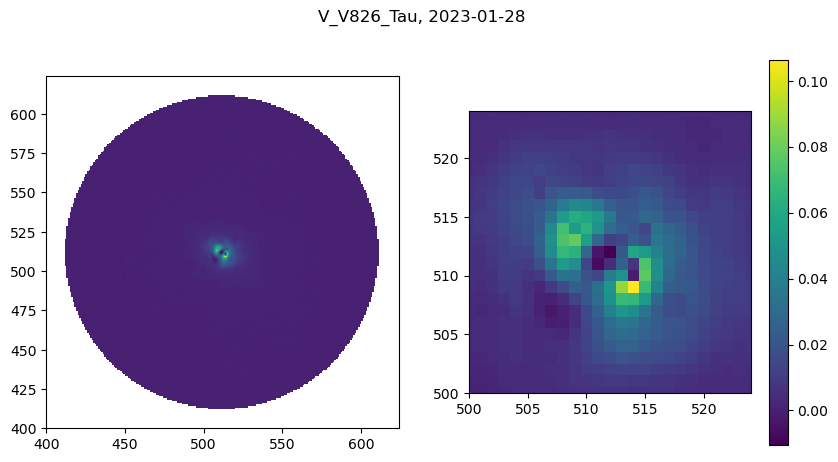

In [25]:
for i in range(len(single_stars)):
    rest = subtract_star(star_data(i, single_stars), med_arr)
    name, date = star_info(i, single_stars)
#     plt.title(f'{name}, {date}')
#     plt.imshow(rest)
#     plt.colorbar()
#     plt.xlim(500, 524)
#     plt.ylim(500, 524)
#     plt.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rest)
    plt.xlim(400, 624)
    plt.ylim(400, 624)

    plt.subplot(1,2,2)
    plt.imshow(rest)
    plt.colorbar()
    plt.xlim(500, 524)
    plt.ylim(500, 524)

    plt.suptitle(f'{name}, {date}')
    plt.show()

In [26]:
subtract_star(star_data(path_sin, 1), med_arr)
name, date = star_info(path_sin, 1)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(500, 524)
plt.ylim(500, 524)
plt.show()

NameError: name 'path_sin' is not defined

# .reg files
1. Want to open them
2. Want to be able to read them
3. Search for key word circle
4. Save x and y coordinate
    - Are all coordinates equally long? --> if not begin next at ,
    - Do not save radius too

In [ ]:
def find_x_y_reg(file, loc_circle, sep):
    ''' Opens the .reg file and returns the x and y coordinate in the file. loc_circle is the number of the line
    where the information on the circle is stored and sep is the thing used for seperating the x and y coord. '''
    with open(file, 'rt') as reg:
        data_reg = reg.readlines()
        data_reg = data_reg[loc_circle]
    
    first, second = data_reg.find(sep), data_reg.rfind(sep)
    return float(data_reg[7:first]), float(data_reg[(first+1):second])

In [ ]:
x, y = find_x_y_reg(f'data/{star}/{date}/{star}_{date}.reg', 3, ',')

In [ ]:
x